# 1: Imports and Setup

In [1]:

import os
import sys
import json
import gc
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import torch
import torch_geometric
from pathlib import Path
from sklearn.model_selection import KFold, train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Add the parent directory to the Python path
# This allows importing the gnn_dta_mtl package
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(''))))

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")

# Import your package - use absolute import instead of relative
from gnn_dta_mtl import (
    MTL_DTAModel, DTAModel,
    MTL_DTA, DTA,
    CrossValidator, MTLTrainer,
    StructureStandardizer, StructureProcessor, StructureChunkLoader,
    ESMEmbedder,
    add_molecular_properties_parallel,
    compute_ligand_efficiency,
    compute_mean_ligand_efficiency,
    filter_by_properties,
    prepare_mtl_experiment,
    build_mtl_dataset, build_mtl_dataset_optimized,
    evaluate_model,
    plot_results, plot_predictions, create_summary_report,
    ExperimentLogger,
    save_model, save_results, create_output_dir
)

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

Using device: cuda
GPU: NVIDIA L4
Number of GPUs: 1


# 2: Configuration


In [2]:
import os
import json
from pathlib import Path
from datetime import datetime

# Create necessary directories first
base_dirs = [
    '../input/combined',
    '../input/chunk',
    '../input/embeddings',
    '../output/protein',
    '../output/ligand',
    '../output/experiments',
]

for dir_path in base_dirs:
    Path(dir_path).mkdir(parents=True, exist_ok=True)
    print(f"✓ Created: {dir_path}")

CONFIG = {
    # Data paths
    'data_path': '../input/combined/df_combined.parquet',
    'protein_out_dir': '../output/protein',
    'ligand_out_dir': '../output/ligand',
    'structure_chunks_dir': '../input/chunk/',
    'embeddings_dir': '../input/embeddings/',
    'output_dir': '../output/experiments/',
    
    # Task configuration
    'task_cols': ['pKi', 'pEC50', 'pKd (Wang, FEP)', 'pKd', 'pIC50', 'potency'],
    
    # Model configuration
    'model_config': {
        'prot_emb_dim': 1280,
        'prot_gcn_dims': [128, 256, 256],
        'prot_fc_dims': [1024, 128],
        'drug_node_in_dim': [66, 1],
        'drug_node_h_dims': [128, 64],
        'drug_edge_in_dim': [16, 1],
        'drug_edge_h_dims': [32, 1],
        'drug_fc_dims': [1024, 128],
        'mlp_dims': [1024, 512],
        'mlp_dropout': 0.25
    },
    
    # Training configuration
    'training_config': {
        'batch_size': 128,
        'n_epochs': 200,
        'learning_rate': 0.0005,
        'patience': 100,
        'n_folds': 3
    },
    
    # Data filtering
    'filter_config': {
        'min_heavy_atoms': 5,
        'max_heavy_atoms': 75,
        'max_mw': 1000,
        'min_carbons': 4,
        'min_le': 0.05,
        'max_le_norm': 0.003
    },
    
    # Processing
    'n_workers': os.cpu_count() - 1 if os.cpu_count() else 8,
    'chunk_size': 100000,
    'sample_size': None,  # Set to integer to limit data size for testing
    
    # ESM model
    'esm_model_name': 'facebook/esm2_t33_650M_UR50D'
}

# Create experiment directory with timestamp
experiment_name = 'gnn_dta_mtl_experiment'
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
experiment_dir = Path(CONFIG['output_dir']) / f"{experiment_name}_{timestamp}"

# Create subdirectories
(experiment_dir / 'models').mkdir(parents=True, exist_ok=True)
(experiment_dir / 'results').mkdir(parents=True, exist_ok=True)
(experiment_dir / 'figures').mkdir(parents=True, exist_ok=True)
(experiment_dir / 'logs').mkdir(parents=True, exist_ok=True)

CONFIG['experiment_dir'] = str(experiment_dir)

# Save configuration
config_path = experiment_dir / 'config.json'
with open(config_path, 'w') as f:
    json.dump(CONFIG, f, indent=2)

print(f"✓ Experiment directory: {CONFIG['experiment_dir']}")
print(f"✓ Configuration saved to: {config_path}")

✓ Created: ../input/combined
✓ Created: ../input/chunk
✓ Created: ../input/embeddings
✓ Created: ../output/protein
✓ Created: ../output/ligand
✓ Created: ../output/experiments
✓ Experiment directory: ../output/experiments/gnn_dta_mtl_experiment_20250911_130831
✓ Configuration saved to: ../output/experiments/gnn_dta_mtl_experiment_20250911_130831/config.json


# 3 : Prepare MTL Experiment

In [3]:
df = pd.read_parquet("./binding_set.parquet")

In [4]:

# Calculate task ranges for weighting
task_ranges = prepare_mtl_experiment(df, CONFIG['task_cols'])

# Create task statistics
print("\nTask Statistics:")
for task in CONFIG['task_cols']:
    if task in df.columns:
        valid_values = df[task].dropna()
        if len(valid_values) > 0:
            print(f"{task}:")
            print(f"  Count: {len(valid_values)}")
            print(f"  Mean: {valid_values.mean():.2f}")
            print(f"  Std: {valid_values.std():.2f}")
            print(f"  Range: [{valid_values.min():.2f}, {valid_values.max():.2f}]")

Task ranges for weighting:
  pKi: range=8.88, weight=0.0670
  pEC50: range=7.47, weight=0.0797
  pKd (Wang, FEP): range=4.90, weight=0.1214
  pKd: range=10.11, weight=0.0589
  pIC50: range=7.67, weight=0.0776
  potency: range=1.00, weight=0.5953

Task Statistics:
pKi:
  Count: 1383
  Mean: 6.72
  Std: 1.86
  Range: [3.04, 11.92]
pEC50:
  Count: 183
  Mean: 7.29
  Std: 1.67
  Range: [3.42, 10.89]
pKd (Wang, FEP):
  Count: 1894
  Mean: 7.22
  Std: 1.00
  Range: [4.24, 9.14]
pKd:
  Count: 952
  Mean: 6.78
  Std: 1.86
  Range: [3.01, 13.11]
pIC50:
  Count: 1278
  Mean: 6.91
  Std: 1.47
  Range: [3.01, 10.68]


# 4 : Cross-Validation Training

In [5]:
from rdkit import RDLogger

# Disable RDKit warnings
RDLogger.DisableLog('rdApp.*')


In [6]:
# Cell 9: Cross-Validation Training
# Initialize cross-validator
cv = CrossValidator(
    model_config=CONFIG['model_config'],
    task_cols=CONFIG['task_cols'],
    task_ranges=task_ranges,
    n_folds=CONFIG['training_config']['n_folds'],
    batch_size=CONFIG['training_config']['batch_size'],
    n_epochs=CONFIG['training_config']['n_epochs'],
    learning_rate=CONFIG['training_config']['learning_rate'],
    patience=CONFIG['training_config']['patience'],
    device=device,
    seed=SEED
)


In [7]:
CONFIG['task_cols']

['pKi', 'pEC50', 'pKd (Wang, FEP)', 'pKd', 'pIC50', 'potency']

In [8]:

# Create chunk loader
chunk_loader = StructureChunkLoader(
    chunk_dir=CONFIG['structure_chunks_dir'],
    cache_size=2
)



Loaded 5690 structures from 1 chunks


In [ ]:

# Run cross-validation
print("\nStarting cross-validation...")
cv_results = cv.run(df, chunk_loader)



Starting cross-validation...

Starting 3-fold cross-validation...

Fold 1 sizes:
  Train: 3414
  Valid: 379
  Test:  1897
Loading structures for 3414 unique proteins...


Building dataset: 100%|██████████| 3414/3414 [00:42<00:00, 80.17it/s]


Loading structures for 379 unique proteins...


Building dataset: 100%|██████████| 379/379 [00:06<00:00, 59.11it/s]


Loading structures for 1897 unique proteins...


Building dataset: 100%|██████████| 1897/1897 [00:23<00:00, 79.61it/s]



FOLD 1/3


Evaluating: 100%|██████████| 15/15 [00:04<00:00,  3.34it/s]



Fold 2 sizes:
  Train: 3414
  Valid: 379
  Test:  1897
Loading structures for 3414 unique proteins...


Building dataset: 100%|██████████| 3414/3414 [00:42<00:00, 79.79it/s]


Loading structures for 379 unique proteins...


Building dataset: 100%|██████████| 379/379 [00:04<00:00, 84.90it/s]


Loading structures for 1897 unique proteins...


Building dataset: 100%|██████████| 1897/1897 [00:22<00:00, 83.62it/s]



FOLD 2/3


Fold 2:  47%|████▋     | 94/200 [25:22<28:36, 16.20s/it, train=0.0363, val=0.0479]

In [ ]:
# Print summary
cv.print_summary()

# Save CV results
save_results(
    cv_results, 
    os.path.join(CONFIG['experiment_dir'], 'results', 'cv_results.pkl'),
    format='pickle'
)

# 4 : Full Training on All Data

In [ ]:
# Create train/valid/test splits
from gnn_dta_mtl.datasets import create_data_splits

splits = create_data_splits(
    df,
    split_method='random',  # or 'scaffold', 'protein', 'drug'
    split_frac=[0.7, 0.1, 0.2],
    seed=SEED
)

df_train = splits['train']
df_valid = splits['valid']
df_test = splits['test']

print(f"Train: {len(df_train)}, Valid: {len(df_valid)}, Test: {len(df_test)}")

# Build datasets
train_dataset = build_mtl_dataset_optimized(df_train, chunk_loader, CONFIG['task_cols'])
valid_dataset = build_mtl_dataset_optimized(df_valid, chunk_loader, CONFIG['task_cols'])
test_dataset = build_mtl_dataset_optimized(df_test, chunk_loader, CONFIG['task_cols'])

# Create data loaders
train_loader = torch_geometric.loader.DataLoader(
    train_dataset,
    batch_size=CONFIG['training_config']['batch_size'],
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

valid_loader = torch_geometric.loader.DataLoader(
    valid_dataset,
    batch_size=CONFIG['training_config']['batch_size'],
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

test_loader = torch_geometric.loader.DataLoader(
    test_dataset,
    batch_size=CONFIG['training_config']['batch_size'],
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

# Create model
model = MTL_DTAModel(
    task_names=CONFIG['task_cols'],
    **CONFIG['model_config']
).to(device)

# Initialize trainer
trainer = MTLTrainer(
    model=model,
    task_cols=CONFIG['task_cols'],
    task_ranges=task_ranges,
    device=device,
    learning_rate=CONFIG['training_config']['learning_rate']
)

# Train model
print("\nTraining model...")
history = trainer.train(
    train_loader,
    valid_loader,
    n_epochs=CONFIG['training_config']['n_epochs'],
    patience=CONFIG['training_config']['patience'],
    verbose=True
)

# Save model
save_model(
    model,
    os.path.join(CONFIG['experiment_dir'], 'models', 'final_model.pt'),
    metrics=history
)

Training: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]



Epoch 44/200
  Train Loss: 0.0640
  Valid Loss: 0.0677
  pKi: RMSE=1.118, R²=0.644
  pEC50: RMSE=1.238, R²=0.345
  pKd (Wang, FEP): RMSE=0.593, R²=0.669
  pKd: RMSE=0.944, R²=0.734
  pIC50: RMSE=1.067, R²=0.494


Training: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]



Epoch 45/200
  Train Loss: 0.0631
  Valid Loss: 0.0623
  pKi: RMSE=1.147, R²=0.626
  pEC50: RMSE=1.381, R²=0.185
  pKd (Wang, FEP): RMSE=0.472, R²=0.790
  pKd: RMSE=0.934, R²=0.740
  pIC50: RMSE=1.009, R²=0.547


Training: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]



Epoch 46/200
  Train Loss: 0.0638
  Valid Loss: 0.0612
  pKi: RMSE=1.126, R²=0.639
  pEC50: RMSE=1.246, R²=0.337
  pKd (Wang, FEP): RMSE=0.481, R²=0.782
  pKd: RMSE=0.901, R²=0.758
  pIC50: RMSE=1.029, R²=0.530


Training: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]



Epoch 47/200
  Train Loss: 0.0636
  Valid Loss: 0.0722
  pKi: RMSE=1.152, R²=0.622
  pEC50: RMSE=1.610, R²=-0.108
  pKd (Wang, FEP): RMSE=0.543, R²=0.722
  pKd: RMSE=0.989, R²=0.708
  pIC50: RMSE=1.123, R²=0.440


Training: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]



Epoch 48/200
  Train Loss: 0.0654
  Valid Loss: 0.0647
  pKi: RMSE=1.117, R²=0.645
  pEC50: RMSE=1.016, R²=0.559
  pKd (Wang, FEP): RMSE=0.468, R²=0.794
  pKd: RMSE=1.078, R²=0.653
  pIC50: RMSE=1.095, R²=0.467


Training: 100%|██████████| 32/32 [00:16<00:00,  1.94it/s]



Epoch 49/200
  Train Loss: 0.0630
  Valid Loss: 0.0822
  pKi: RMSE=1.102, R²=0.654
  pEC50: RMSE=1.338, R²=0.235
  pKd (Wang, FEP): RMSE=0.840, R²=0.335
  pKd: RMSE=0.955, R²=0.728
  pIC50: RMSE=1.023, R²=0.535


Training: 100%|██████████| 32/32 [00:17<00:00,  1.87it/s]



Epoch 50/200
  Train Loss: 0.0620
  Valid Loss: 0.0542
  pKi: RMSE=1.051, R²=0.686
  pEC50: RMSE=0.983, R²=0.587
  pKd (Wang, FEP): RMSE=0.484, R²=0.780
  pKd: RMSE=0.868, R²=0.775
  pIC50: RMSE=0.969, R²=0.583


Training: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]



Epoch 51/200
  Train Loss: 0.0662
  Valid Loss: 0.0557
  pKi: RMSE=1.074, R²=0.671
  pEC50: RMSE=1.106, R²=0.477
  pKd (Wang, FEP): RMSE=0.452, R²=0.808
  pKd: RMSE=0.906, R²=0.755
  pIC50: RMSE=0.976, R²=0.576


Training: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]



Epoch 52/200
  Train Loss: 0.0573
  Valid Loss: 0.0633
  pKi: RMSE=1.014, R²=0.708
  pEC50: RMSE=1.336, R²=0.237
  pKd (Wang, FEP): RMSE=0.633, R²=0.623
  pKd: RMSE=0.908, R²=0.754
  pIC50: RMSE=0.955, R²=0.595


Training: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]



Epoch 53/200
  Train Loss: 0.0592
  Valid Loss: 0.0543
  pKi: RMSE=1.041, R²=0.692
  pEC50: RMSE=1.086, R²=0.496
  pKd (Wang, FEP): RMSE=0.457, R²=0.803
  pKd: RMSE=0.899, R²=0.759
  pIC50: RMSE=0.993, R²=0.562


Training: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]



Epoch 54/200
  Train Loss: 0.0669
  Valid Loss: 0.0665
  pKi: RMSE=1.159, R²=0.618
  pEC50: RMSE=0.950, R²=0.614
  pKd (Wang, FEP): RMSE=0.502, R²=0.763
  pKd: RMSE=1.079, R²=0.653
  pIC50: RMSE=1.091, R²=0.471


Training: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]



Epoch 55/200
  Train Loss: 0.0582
  Valid Loss: 0.0562
  pKi: RMSE=1.069, R²=0.675
  pEC50: RMSE=1.205, R²=0.379
  pKd (Wang, FEP): RMSE=0.494, R²=0.770
  pKd: RMSE=0.871, R²=0.774
  pIC50: RMSE=0.982, R²=0.572


Training: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]



Epoch 56/200
  Train Loss: 0.0553
  Valid Loss: 0.0596
  pKi: RMSE=1.074, R²=0.672
  pEC50: RMSE=1.293, R²=0.285
  pKd (Wang, FEP): RMSE=0.554, R²=0.711
  pKd: RMSE=0.885, R²=0.766
  pIC50: RMSE=0.941, R²=0.607


Training: 100%|██████████| 32/32 [00:16<00:00,  1.94it/s]



Epoch 57/200
  Train Loss: 0.0550
  Valid Loss: 0.0536
  pKi: RMSE=1.018, R²=0.705
  pEC50: RMSE=1.071, R²=0.510
  pKd (Wang, FEP): RMSE=0.491, R²=0.773
  pKd: RMSE=0.863, R²=0.778
  pIC50: RMSE=0.951, R²=0.598


Training: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]



Epoch 58/200
  Train Loss: 0.0548
  Valid Loss: 0.0595
  pKi: RMSE=1.053, R²=0.685
  pEC50: RMSE=1.269, R²=0.312
  pKd (Wang, FEP): RMSE=0.536, R²=0.730
  pKd: RMSE=0.894, R²=0.761
  pIC50: RMSE=0.989, R²=0.565


Training: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s]



Epoch 59/200
  Train Loss: 0.0542
  Valid Loss: 0.0661
  pKi: RMSE=1.131, R²=0.636
  pEC50: RMSE=1.163, R²=0.422
  pKd (Wang, FEP): RMSE=0.629, R²=0.627
  pKd: RMSE=0.906, R²=0.755
  pIC50: RMSE=0.973, R²=0.579


Training: 100%|██████████| 32/32 [00:49<00:00,  1.56s/it]



Epoch 60/200
  Train Loss: 0.0540
  Valid Loss: 0.0530
  pKi: RMSE=1.056, R²=0.682
  pEC50: RMSE=0.915, R²=0.642
  pKd (Wang, FEP): RMSE=0.449, R²=0.810
  pKd: RMSE=0.872, R²=0.773
  pIC50: RMSE=0.962, R²=0.589


Training: 100%|██████████| 32/32 [00:25<00:00,  1.27it/s]



Epoch 61/200
  Train Loss: 0.0530
  Valid Loss: 0.0484
  pKi: RMSE=0.954, R²=0.741
  pEC50: RMSE=0.921, R²=0.638
  pKd (Wang, FEP): RMSE=0.442, R²=0.816
  pKd: RMSE=0.875, R²=0.772
  pIC50: RMSE=0.937, R²=0.610


Training: 100%|██████████| 32/32 [01:38<00:00,  3.08s/it]



Epoch 62/200
  Train Loss: 0.0522
  Valid Loss: 0.0554
  pKi: RMSE=1.041, R²=0.691
  pEC50: RMSE=1.194, R²=0.390
  pKd (Wang, FEP): RMSE=0.500, R²=0.764
  pKd: RMSE=0.905, R²=0.755
  pIC50: RMSE=0.929, R²=0.616


Training: 100%|██████████| 32/32 [00:17<00:00,  1.88it/s]



Epoch 63/200
  Train Loss: 0.0543
  Valid Loss: 0.0616
  pKi: RMSE=0.983, R²=0.725
  pEC50: RMSE=1.106, R²=0.477
  pKd (Wang, FEP): RMSE=0.643, R²=0.611
  pKd: RMSE=0.935, R²=0.739
  pIC50: RMSE=0.956, R²=0.594


Training: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]



Epoch 64/200
  Train Loss: 0.0575
  Valid Loss: 0.0961
  pKi: RMSE=1.120, R²=0.643
  pEC50: RMSE=1.421, R²=0.137
  pKd (Wang, FEP): RMSE=0.947, R²=0.154
  pKd: RMSE=1.000, R²=0.701
  pIC50: RMSE=1.126, R²=0.437


Training: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s]



Epoch 65/200
  Train Loss: 0.0617
  Valid Loss: 0.0579
  pKi: RMSE=1.094, R²=0.660
  pEC50: RMSE=1.002, R²=0.570
  pKd (Wang, FEP): RMSE=0.549, R²=0.716
  pKd: RMSE=0.939, R²=0.737
  pIC50: RMSE=0.926, R²=0.619


Training: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]



Epoch 66/200
  Train Loss: 0.0581
  Valid Loss: 0.0500
  pKi: RMSE=0.951, R²=0.742
  pEC50: RMSE=0.987, R²=0.583
  pKd (Wang, FEP): RMSE=0.465, R²=0.796
  pKd: RMSE=0.849, R²=0.785
  pIC50: RMSE=0.970, R²=0.582


Training: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]



Epoch 67/200
  Train Loss: 0.0483
  Valid Loss: 0.0577
  pKi: RMSE=1.052, R²=0.685
  pEC50: RMSE=1.004, R²=0.569
  pKd (Wang, FEP): RMSE=0.430, R²=0.826
  pKd: RMSE=0.860, R²=0.779
  pIC50: RMSE=1.119, R²=0.443


Training: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]



Epoch 68/200
  Train Loss: 0.0501
  Valid Loss: 0.0554
  pKi: RMSE=1.052, R²=0.685
  pEC50: RMSE=0.967, R²=0.600
  pKd (Wang, FEP): RMSE=0.537, R²=0.728
  pKd: RMSE=0.857, R²=0.781
  pIC50: RMSE=0.936, R²=0.610


Training: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]



Epoch 69/200
  Train Loss: 0.0510
  Valid Loss: 0.0674
  pKi: RMSE=1.110, R²=0.650
  pEC50: RMSE=1.030, R²=0.547
  pKd (Wang, FEP): RMSE=0.690, R²=0.552
  pKd: RMSE=0.870, R²=0.774
  pIC50: RMSE=0.975, R²=0.578


Training: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]



Epoch 70/200
  Train Loss: 0.0508
  Valid Loss: 0.0543
  pKi: RMSE=0.970, R²=0.732
  pEC50: RMSE=1.274, R²=0.307
  pKd (Wang, FEP): RMSE=0.482, R²=0.781
  pKd: RMSE=0.956, R²=0.727
  pIC50: RMSE=0.950, R²=0.599


Training: 100%|██████████| 32/32 [00:16<00:00,  1.94it/s]



Epoch 71/200
  Train Loss: 0.0507
  Valid Loss: 0.0481
  pKi: RMSE=0.942, R²=0.747
  pEC50: RMSE=1.021, R²=0.554
  pKd (Wang, FEP): RMSE=0.423, R²=0.832
  pKd: RMSE=0.846, R²=0.786
  pIC50: RMSE=0.956, R²=0.594


Training: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]



Epoch 72/200
  Train Loss: 0.0435
  Valid Loss: 0.0504
  pKi: RMSE=0.922, R²=0.758
  pEC50: RMSE=0.963, R²=0.603
  pKd (Wang, FEP): RMSE=0.482, R²=0.781
  pKd: RMSE=0.848, R²=0.785
  pIC50: RMSE=0.965, R²=0.586


Training: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s]



Epoch 73/200
  Train Loss: 0.0460
  Valid Loss: 0.0681
  pKi: RMSE=0.941, R²=0.748
  pEC50: RMSE=1.078, R²=0.503
  pKd (Wang, FEP): RMSE=0.738, R²=0.487
  pKd: RMSE=0.902, R²=0.757
  pIC50: RMSE=1.024, R²=0.534


Training: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]



Epoch 74/200
  Train Loss: 0.0505
  Valid Loss: 0.0483
  pKi: RMSE=0.960, R²=0.738
  pEC50: RMSE=1.075, R²=0.506
  pKd (Wang, FEP): RMSE=0.397, R²=0.851
  pKd: RMSE=0.876, R²=0.771
  pIC50: RMSE=0.956, R²=0.594


Training: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]



Epoch 75/200
  Train Loss: 0.0440
  Valid Loss: 0.0513
  pKi: RMSE=0.980, R²=0.726
  pEC50: RMSE=0.918, R²=0.640
  pKd (Wang, FEP): RMSE=0.411, R²=0.841
  pKd: RMSE=0.918, R²=0.748
  pIC50: RMSE=0.995, R²=0.560


Training: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]



Epoch 76/200
  Train Loss: 0.0477
  Valid Loss: 0.0787
  pKi: RMSE=1.063, R²=0.678
  pEC50: RMSE=1.337, R²=0.235
  pKd (Wang, FEP): RMSE=0.876, R²=0.278
  pKd: RMSE=0.891, R²=0.763
  pIC50: RMSE=0.926, R²=0.619


Training: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]



Epoch 77/200
  Train Loss: 0.0511
  Valid Loss: 0.0479
  pKi: RMSE=0.958, R²=0.739
  pEC50: RMSE=0.897, R²=0.656
  pKd (Wang, FEP): RMSE=0.431, R²=0.825
  pKd: RMSE=0.906, R²=0.755
  pIC50: RMSE=0.924, R²=0.621


Training: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]



Epoch 78/200
  Train Loss: 0.0433
  Valid Loss: 0.0538
  pKi: RMSE=0.979, R²=0.727
  pEC50: RMSE=1.237, R²=0.346
  pKd (Wang, FEP): RMSE=0.531, R²=0.734
  pKd: RMSE=0.872, R²=0.773
  pIC50: RMSE=0.911, R²=0.631


Training: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]



Epoch 79/200
  Train Loss: 0.0459
  Valid Loss: 0.0455
  pKi: RMSE=0.943, R²=0.747
  pEC50: RMSE=1.109, R²=0.475
  pKd (Wang, FEP): RMSE=0.393, R²=0.855
  pKd: RMSE=0.837, R²=0.791
  pIC50: RMSE=0.893, R²=0.646


Training: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]



Epoch 80/200
  Train Loss: 0.0411
  Valid Loss: 0.0532
  pKi: RMSE=0.983, R²=0.725
  pEC50: RMSE=0.986, R²=0.584
  pKd (Wang, FEP): RMSE=0.483, R²=0.780
  pKd: RMSE=0.880, R²=0.769
  pIC50: RMSE=0.974, R²=0.579


Training: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]



Epoch 81/200
  Train Loss: 0.0447
  Valid Loss: 0.0780
  pKi: RMSE=1.001, R²=0.715
  pEC50: RMSE=1.610, R²=-0.108
  pKd (Wang, FEP): RMSE=0.834, R²=0.345
  pKd: RMSE=0.913, R²=0.751
  pIC50: RMSE=0.957, R²=0.593


Training: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]



Epoch 82/200
  Train Loss: 0.0464
  Valid Loss: 0.0471
  pKi: RMSE=0.937, R²=0.750
  pEC50: RMSE=1.131, R²=0.453
  pKd (Wang, FEP): RMSE=0.395, R²=0.853
  pKd: RMSE=0.888, R²=0.765
  pIC50: RMSE=0.913, R²=0.630


Training: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]



Epoch 83/200
  Train Loss: 0.0396
  Valid Loss: 0.0621
  pKi: RMSE=0.938, R²=0.749
  pEC50: RMSE=1.488, R²=0.054
  pKd (Wang, FEP): RMSE=0.659, R²=0.590
  pKd: RMSE=0.882, R²=0.768
  pIC50: RMSE=0.922, R²=0.622


Training: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]



Epoch 84/200
  Train Loss: 0.0457
  Valid Loss: 0.0514
  pKi: RMSE=1.001, R²=0.715
  pEC50: RMSE=1.140, R²=0.444
  pKd (Wang, FEP): RMSE=0.423, R²=0.831
  pKd: RMSE=0.931, R²=0.741
  pIC50: RMSE=0.923, R²=0.622


Training: 100%|██████████| 32/32 [00:17<00:00,  1.87it/s]



Epoch 85/200
  Train Loss: 0.0415
  Valid Loss: 0.0457
  pKi: RMSE=0.930, R²=0.754
  pEC50: RMSE=0.863, R²=0.682
  pKd (Wang, FEP): RMSE=0.387, R²=0.859
  pKd: RMSE=0.875, R²=0.771
  pIC50: RMSE=0.958, R²=0.592


Training: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]



Epoch 86/200
  Train Loss: 0.0393
  Valid Loss: 0.0464
  pKi: RMSE=0.945, R²=0.746
  pEC50: RMSE=0.878, R²=0.670
  pKd (Wang, FEP): RMSE=0.423, R²=0.831
  pKd: RMSE=0.833, R²=0.793
  pIC50: RMSE=0.948, R²=0.601


Training: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]



Epoch 87/200
  Train Loss: 0.0398
  Valid Loss: 0.0490
  pKi: RMSE=0.927, R²=0.755
  pEC50: RMSE=1.321, R²=0.254
  pKd (Wang, FEP): RMSE=0.468, R²=0.794
  pKd: RMSE=0.883, R²=0.767
  pIC50: RMSE=0.873, R²=0.661


Training: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]



Epoch 88/200
  Train Loss: 0.0439
  Valid Loss: 0.0496
  pKi: RMSE=0.920, R²=0.759
  pEC50: RMSE=1.616, R²=-0.116
  pKd (Wang, FEP): RMSE=0.370, R²=0.871
  pKd: RMSE=0.906, R²=0.755
  pIC50: RMSE=0.894, R²=0.645


Training: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]



Epoch 89/200
  Train Loss: 0.0392
  Valid Loss: 0.0425
  pKi: RMSE=0.850, R²=0.794
  pEC50: RMSE=1.147, R²=0.438
  pKd (Wang, FEP): RMSE=0.384, R²=0.861
  pKd: RMSE=0.859, R²=0.780
  pIC50: RMSE=0.869, R²=0.664


Training: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]



Epoch 90/200
  Train Loss: 0.0394
  Valid Loss: 0.0471
  pKi: RMSE=0.955, R²=0.740
  pEC50: RMSE=1.178, R²=0.407
  pKd (Wang, FEP): RMSE=0.419, R²=0.835
  pKd: RMSE=0.823, R²=0.798
  pIC50: RMSE=0.889, R²=0.649


Training: 100%|██████████| 32/32 [00:16<00:00,  1.95it/s]



Epoch 91/200
  Train Loss: 0.0426
  Valid Loss: 0.0449
  pKi: RMSE=0.897, R²=0.771
  pEC50: RMSE=1.050, R²=0.529
  pKd (Wang, FEP): RMSE=0.411, R²=0.841
  pKd: RMSE=0.871, R²=0.774
  pIC50: RMSE=0.901, R²=0.639


Training: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]



Epoch 92/200
  Train Loss: 0.0398
  Valid Loss: 0.0496
  pKi: RMSE=0.958, R²=0.739
  pEC50: RMSE=0.933, R²=0.628
  pKd (Wang, FEP): RMSE=0.418, R²=0.835
  pKd: RMSE=0.881, R²=0.768
  pIC50: RMSE=0.965, R²=0.586


Training: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]



Epoch 93/200
  Train Loss: 0.0352
  Valid Loss: 0.0492
  pKi: RMSE=0.942, R²=0.747
  pEC50: RMSE=1.248, R²=0.335
  pKd (Wang, FEP): RMSE=0.477, R²=0.786
  pKd: RMSE=0.798, R²=0.810
  pIC50: RMSE=0.915, R²=0.628


Training: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]



Epoch 94/200
  Train Loss: 0.0360
  Valid Loss: 0.0451
  pKi: RMSE=0.885, R²=0.777
  pEC50: RMSE=0.981, R²=0.589
  pKd (Wang, FEP): RMSE=0.463, R²=0.798
  pKd: RMSE=0.774, R²=0.821
  pIC50: RMSE=0.877, R²=0.658


Training: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]



Epoch 95/200
  Train Loss: 0.0346
  Valid Loss: 0.0436
  pKi: RMSE=0.942, R²=0.747
  pEC50: RMSE=0.915, R²=0.642
  pKd (Wang, FEP): RMSE=0.416, R²=0.837
  pKd: RMSE=0.726, R²=0.842
  pIC50: RMSE=0.891, R²=0.647


Training: 100%|██████████| 32/32 [00:17<00:00,  1.88it/s]



Epoch 96/200
  Train Loss: 0.0352
  Valid Loss: 0.0537
  pKi: RMSE=0.960, R²=0.738
  pEC50: RMSE=1.180, R²=0.405
  pKd (Wang, FEP): RMSE=0.601, R²=0.659
  pKd: RMSE=0.804, R²=0.807
  pIC50: RMSE=0.861, R²=0.670


Training: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]



Epoch 97/200
  Train Loss: 0.0373
  Valid Loss: 0.0496
  pKi: RMSE=0.966, R²=0.735
  pEC50: RMSE=1.105, R²=0.478
  pKd (Wang, FEP): RMSE=0.502, R²=0.763
  pKd: RMSE=0.796, R²=0.811
  pIC50: RMSE=0.899, R²=0.641


Training: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]



Epoch 98/200
  Train Loss: 0.0360
  Valid Loss: 0.0456
  pKi: RMSE=0.933, R²=0.752
  pEC50: RMSE=1.031, R²=0.546
  pKd (Wang, FEP): RMSE=0.484, R²=0.779
  pKd: RMSE=0.771, R²=0.823
  pIC50: RMSE=0.847, R²=0.681


Training: 100%|██████████| 32/32 [00:16<00:00,  1.94it/s]



Epoch 99/200
  Train Loss: 0.0343
  Valid Loss: 0.0471
  pKi: RMSE=0.874, R²=0.783
  pEC50: RMSE=0.934, R²=0.627
  pKd (Wang, FEP): RMSE=0.450, R²=0.809
  pKd: RMSE=0.878, R²=0.770
  pIC50: RMSE=0.932, R²=0.614


Training: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]



Epoch 100/200
  Train Loss: 0.0377
  Valid Loss: 0.0517
  pKi: RMSE=0.920, R²=0.759
  pEC50: RMSE=1.237, R²=0.346
  pKd (Wang, FEP): RMSE=0.530, R²=0.736
  pKd: RMSE=0.887, R²=0.765
  pIC50: RMSE=0.890, R²=0.648


Training: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]



Epoch 101/200
  Train Loss: 0.0332
  Valid Loss: 0.0599
  pKi: RMSE=1.037, R²=0.694
  pEC50: RMSE=0.871, R²=0.676
  pKd (Wang, FEP): RMSE=0.519, R²=0.746
  pKd: RMSE=1.008, R²=0.697
  pIC50: RMSE=1.041, R²=0.518


Training: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]



Epoch 102/200
  Train Loss: 0.0337
  Valid Loss: 0.0418
  pKi: RMSE=0.933, R²=0.752
  pEC50: RMSE=0.968, R²=0.599
  pKd (Wang, FEP): RMSE=0.353, R²=0.883
  pKd: RMSE=0.792, R²=0.813
  pIC50: RMSE=0.882, R²=0.654


Training: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s]



Epoch 103/200
  Train Loss: 0.0316
  Valid Loss: 0.0421
  pKi: RMSE=0.978, R²=0.728
  pEC50: RMSE=0.956, R²=0.610
  pKd (Wang, FEP): RMSE=0.359, R²=0.878
  pKd: RMSE=0.881, R²=0.768
  pIC50: RMSE=0.813, R²=0.707


Training: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]



Epoch 104/200
  Train Loss: 0.0296
  Valid Loss: 0.0486
  pKi: RMSE=0.957, R²=0.739
  pEC50: RMSE=1.082, R²=0.500
  pKd (Wang, FEP): RMSE=0.467, R²=0.794
  pKd: RMSE=0.834, R²=0.792
  pIC50: RMSE=0.914, R²=0.629


Training: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]



Epoch 105/200
  Train Loss: 0.0320
  Valid Loss: 0.0495
  pKi: RMSE=0.885, R²=0.777
  pEC50: RMSE=1.266, R²=0.315
  pKd (Wang, FEP): RMSE=0.497, R²=0.767
  pKd: RMSE=0.881, R²=0.768
  pIC50: RMSE=0.909, R²=0.633


Training: 100%|██████████| 32/32 [00:16<00:00,  1.94it/s]



Epoch 106/200
  Train Loss: 0.0316
  Valid Loss: 0.0547
  pKi: RMSE=1.006, R²=0.712
  pEC50: RMSE=0.974, R²=0.594
  pKd (Wang, FEP): RMSE=0.414, R²=0.838
  pKd: RMSE=1.046, R²=0.673
  pIC50: RMSE=1.004, R²=0.552


Training: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]



Epoch 107/200
  Train Loss: 0.0353
  Valid Loss: 0.0511
  pKi: RMSE=0.948, R²=0.744
  pEC50: RMSE=0.910, R²=0.646
  pKd (Wang, FEP): RMSE=0.517, R²=0.749
  pKd: RMSE=0.821, R²=0.799
  pIC50: RMSE=0.948, R²=0.600


Training: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s]



Epoch 108/200
  Train Loss: 0.0311
  Valid Loss: 0.0631
  pKi: RMSE=0.973, R²=0.731
  pEC50: RMSE=1.162, R²=0.423
  pKd (Wang, FEP): RMSE=0.665, R²=0.583
  pKd: RMSE=0.917, R²=0.749
  pIC50: RMSE=1.007, R²=0.550


Training: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]



Epoch 109/200
  Train Loss: 0.0371
  Valid Loss: 0.0418
  pKi: RMSE=0.901, R²=0.769
  pEC50: RMSE=1.175, R²=0.410
  pKd (Wang, FEP): RMSE=0.369, R²=0.872
  pKd: RMSE=0.879, R²=0.770
  pIC50: RMSE=0.827, R²=0.696


Training: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]



Epoch 110/200
  Train Loss: 0.0325
  Valid Loss: 0.0503
  pKi: RMSE=0.980, R²=0.727
  pEC50: RMSE=0.955, R²=0.610
  pKd (Wang, FEP): RMSE=0.497, R²=0.767
  pKd: RMSE=0.861, R²=0.779
  pIC50: RMSE=0.911, R²=0.631


Training: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]



Epoch 111/200
  Train Loss: 0.0307
  Valid Loss: 0.0484
  pKi: RMSE=1.018, R²=0.705
  pEC50: RMSE=1.114, R²=0.469
  pKd (Wang, FEP): RMSE=0.454, R²=0.805
  pKd: RMSE=0.853, R²=0.783
  pIC50: RMSE=0.867, R²=0.666


Training: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]



Epoch 112/200
  Train Loss: 0.0351
  Valid Loss: 0.0494
  pKi: RMSE=0.998, R²=0.716
  pEC50: RMSE=1.105, R²=0.478
  pKd (Wang, FEP): RMSE=0.525, R²=0.741
  pKd: RMSE=0.841, R²=0.789
  pIC50: RMSE=0.817, R²=0.704


Training: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s]



Epoch 113/200
  Train Loss: 0.0316
  Valid Loss: 0.0461
  pKi: RMSE=0.934, R²=0.752
  pEC50: RMSE=0.933, R²=0.628
  pKd (Wang, FEP): RMSE=0.423, R²=0.832
  pKd: RMSE=0.800, R²=0.809
  pIC50: RMSE=0.922, R²=0.623


Training: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]



Epoch 114/200
  Train Loss: 0.0285
  Valid Loss: 0.0440
  pKi: RMSE=0.920, R²=0.759
  pEC50: RMSE=0.837, R²=0.700
  pKd (Wang, FEP): RMSE=0.462, R²=0.799
  pKd: RMSE=0.836, R²=0.792
  pIC50: RMSE=0.832, R²=0.693


Training: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s]



Epoch 115/200
  Train Loss: 0.0281
  Valid Loss: 0.0389
  pKi: RMSE=0.899, R²=0.770
  pEC50: RMSE=1.067, R²=0.513
  pKd (Wang, FEP): RMSE=0.335, R²=0.894
  pKd: RMSE=0.813, R²=0.803
  pIC50: RMSE=0.792, R²=0.721


Training: 100%|██████████| 32/32 [00:16<00:00,  1.94it/s]



Epoch 116/200
  Train Loss: 0.0281
  Valid Loss: 0.0404
  pKi: RMSE=0.892, R²=0.774
  pEC50: RMSE=1.077, R²=0.504
  pKd (Wang, FEP): RMSE=0.431, R²=0.825
  pKd: RMSE=0.724, R²=0.843
  pIC50: RMSE=0.808, R²=0.710


Training: 100%|██████████| 32/32 [00:17<00:00,  1.88it/s]



Epoch 117/200
  Train Loss: 0.0306
  Valid Loss: 0.0523
  pKi: RMSE=0.985, R²=0.724
  pEC50: RMSE=1.181, R²=0.404
  pKd (Wang, FEP): RMSE=0.549, R²=0.717
  pKd: RMSE=0.825, R²=0.797
  pIC50: RMSE=0.875, R²=0.660


Training: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]



Epoch 118/200
  Train Loss: 0.0286
  Valid Loss: 0.0393
  pKi: RMSE=0.898, R²=0.770
  pEC50: RMSE=1.029, R²=0.547
  pKd (Wang, FEP): RMSE=0.389, R²=0.858
  pKd: RMSE=0.769, R²=0.824
  pIC50: RMSE=0.822, R²=0.700


Training: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]



Epoch 119/200
  Train Loss: 0.0264
  Valid Loss: 0.0473
  pKi: RMSE=0.928, R²=0.755
  pEC50: RMSE=1.033, R²=0.544
  pKd (Wang, FEP): RMSE=0.461, R²=0.799
  pKd: RMSE=0.861, R²=0.779
  pIC50: RMSE=0.912, R²=0.630


Training: 100%|██████████| 32/32 [00:16<00:00,  1.94it/s]



Epoch 120/200
  Train Loss: 0.0294
  Valid Loss: 0.0482
  pKi: RMSE=0.923, R²=0.758
  pEC50: RMSE=1.239, R²=0.344
  pKd (Wang, FEP): RMSE=0.358, R²=0.879
  pKd: RMSE=0.873, R²=0.773
  pIC50: RMSE=1.001, R²=0.555


Training: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]



Epoch 121/200
  Train Loss: 0.0272
  Valid Loss: 0.0439
  pKi: RMSE=0.978, R²=0.728
  pEC50: RMSE=0.846, R²=0.694
  pKd (Wang, FEP): RMSE=0.393, R²=0.854
  pKd: RMSE=0.840, R²=0.789
  pIC50: RMSE=0.866, R²=0.667


Training: 100%|██████████| 32/32 [00:16<00:00,  1.94it/s]



Epoch 122/200
  Train Loss: 0.0272
  Valid Loss: 0.0366
  pKi: RMSE=0.923, R²=0.758
  pEC50: RMSE=0.881, R²=0.668
  pKd (Wang, FEP): RMSE=0.347, R²=0.886
  pKd: RMSE=0.751, R²=0.831
  pIC50: RMSE=0.765, R²=0.740


Training: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]



Epoch 123/200
  Train Loss: 0.0267
  Valid Loss: 0.0524
  pKi: RMSE=1.014, R²=0.708
  pEC50: RMSE=0.961, R²=0.605
  pKd (Wang, FEP): RMSE=0.488, R²=0.775
  pKd: RMSE=0.941, R²=0.736
  pIC50: RMSE=0.870, R²=0.664


Training: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]



Epoch 124/200
  Train Loss: 0.0309
  Valid Loss: 0.0385
  pKi: RMSE=0.925, R²=0.756
  pEC50: RMSE=0.919, R²=0.639
  pKd (Wang, FEP): RMSE=0.368, R²=0.872
  pKd: RMSE=0.767, R²=0.824
  pIC50: RMSE=0.772, R²=0.735


Training: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]



Epoch 125/200
  Train Loss: 0.0263
  Valid Loss: 0.0383
  pKi: RMSE=0.932, R²=0.753
  pEC50: RMSE=1.032, R²=0.545
  pKd (Wang, FEP): RMSE=0.319, R²=0.904
  pKd: RMSE=0.764, R²=0.826
  pIC50: RMSE=0.799, R²=0.716


Training: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]



Epoch 126/200
  Train Loss: 0.0275
  Valid Loss: 0.0393
  pKi: RMSE=0.952, R²=0.742
  pEC50: RMSE=0.980, R²=0.590
  pKd (Wang, FEP): RMSE=0.287, R²=0.922
  pKd: RMSE=0.798, R²=0.810
  pIC50: RMSE=0.827, R²=0.696


Training: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]



Epoch 127/200
  Train Loss: 0.0291
  Valid Loss: 0.0415
  pKi: RMSE=0.964, R²=0.735
  pEC50: RMSE=0.820, R²=0.712
  pKd (Wang, FEP): RMSE=0.315, R²=0.906
  pKd: RMSE=0.795, R²=0.811
  pIC50: RMSE=0.892, R²=0.646


Training: 100%|██████████| 32/32 [00:16<00:00,  1.94it/s]



Epoch 128/200
  Train Loss: 0.0242
  Valid Loss: 0.0394
  pKi: RMSE=0.916, R²=0.761
  pEC50: RMSE=0.885, R²=0.666
  pKd (Wang, FEP): RMSE=0.407, R²=0.844
  pKd: RMSE=0.767, R²=0.824
  pIC50: RMSE=0.783, R²=0.728


Training: 100%|██████████| 32/32 [00:17<00:00,  1.88it/s]



Epoch 129/200
  Train Loss: 0.0235
  Valid Loss: 0.0367
  pKi: RMSE=0.857, R²=0.791
  pEC50: RMSE=0.941, R²=0.622
  pKd (Wang, FEP): RMSE=0.350, R²=0.885
  pKd: RMSE=0.749, R²=0.833
  pIC50: RMSE=0.802, R²=0.714


Training: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]



Epoch 130/200
  Train Loss: 0.0246
  Valid Loss: 0.0417
  pKi: RMSE=0.984, R²=0.724
  pEC50: RMSE=0.891, R²=0.660
  pKd (Wang, FEP): RMSE=0.335, R²=0.894
  pKd: RMSE=0.763, R²=0.826
  pIC50: RMSE=0.858, R²=0.673


Training: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]



Epoch 131/200
  Train Loss: 0.0238
  Valid Loss: 0.0450
  pKi: RMSE=0.942, R²=0.748
  pEC50: RMSE=0.921, R²=0.637
  pKd (Wang, FEP): RMSE=0.343, R²=0.889
  pKd: RMSE=0.847, R²=0.786
  pIC50: RMSE=0.956, R²=0.594


Training: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]



Epoch 132/200
  Train Loss: 0.0241
  Valid Loss: 0.0394
  pKi: RMSE=0.926, R²=0.756
  pEC50: RMSE=1.133, R²=0.451
  pKd (Wang, FEP): RMSE=0.328, R²=0.898
  pKd: RMSE=0.724, R²=0.843
  pIC50: RMSE=0.824, R²=0.698


Training: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]



Epoch 133/200
  Train Loss: 0.0245
  Valid Loss: 0.0365
  pKi: RMSE=0.891, R²=0.774
  pEC50: RMSE=0.941, R²=0.622
  pKd (Wang, FEP): RMSE=0.325, R²=0.901
  pKd: RMSE=0.755, R²=0.830
  pIC50: RMSE=0.807, R²=0.711


Training: 100%|██████████| 32/32 [00:16<00:00,  1.88it/s]



Epoch 134/200
  Train Loss: 0.0257
  Valid Loss: 0.0374
  pKi: RMSE=0.893, R²=0.773
  pEC50: RMSE=0.969, R²=0.598
  pKd (Wang, FEP): RMSE=0.332, R²=0.896
  pKd: RMSE=0.714, R²=0.848
  pIC50: RMSE=0.823, R²=0.699


Training: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s]



Epoch 135/200
  Train Loss: 0.0270
  Valid Loss: 0.0363
  pKi: RMSE=0.893, R²=0.773
  pEC50: RMSE=1.017, R²=0.558
  pKd (Wang, FEP): RMSE=0.296, R²=0.917
  pKd: RMSE=0.738, R²=0.838
  pIC50: RMSE=0.786, R²=0.726


Training: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]



Epoch 136/200
  Train Loss: 0.0255
  Valid Loss: 0.0381
  pKi: RMSE=0.903, R²=0.768
  pEC50: RMSE=0.815, R²=0.716
  pKd (Wang, FEP): RMSE=0.381, R²=0.864
  pKd: RMSE=0.733, R²=0.840
  pIC50: RMSE=0.838, R²=0.688


Training: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]



Epoch 137/200
  Train Loss: 0.0234
  Valid Loss: 0.0373
  pKi: RMSE=0.915, R²=0.762
  pEC50: RMSE=0.892, R²=0.660
  pKd (Wang, FEP): RMSE=0.309, R²=0.910
  pKd: RMSE=0.792, R²=0.813
  pIC50: RMSE=0.803, R²=0.714


Training: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]



Epoch 138/200
  Train Loss: 0.0251
  Valid Loss: 0.0348
  pKi: RMSE=0.891, R²=0.774
  pEC50: RMSE=0.885, R²=0.665
  pKd (Wang, FEP): RMSE=0.310, R²=0.910
  pKd: RMSE=0.758, R²=0.829
  pIC50: RMSE=0.752, R²=0.749


Training: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]



Epoch 139/200
  Train Loss: 0.0223
  Valid Loss: 0.0371
  pKi: RMSE=0.892, R²=0.773
  pEC50: RMSE=0.974, R²=0.595
  pKd (Wang, FEP): RMSE=0.287, R²=0.922
  pKd: RMSE=0.752, R²=0.831
  pIC50: RMSE=0.842, R²=0.685


Training: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s]



Epoch 140/200
  Train Loss: 0.0254
  Valid Loss: 0.0394
  pKi: RMSE=0.909, R²=0.765
  pEC50: RMSE=1.176, R²=0.409
  pKd (Wang, FEP): RMSE=0.371, R²=0.870
  pKd: RMSE=0.815, R²=0.802
  pIC50: RMSE=0.759, R²=0.744


Training: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]



Epoch 141/200
  Train Loss: 0.0239
  Valid Loss: 0.0428
  pKi: RMSE=0.966, R²=0.734
  pEC50: RMSE=0.981, R²=0.589
  pKd (Wang, FEP): RMSE=0.329, R²=0.898
  pKd: RMSE=0.793, R²=0.812
  pIC50: RMSE=0.866, R²=0.667


Training: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]



Epoch 142/200
  Train Loss: 0.0223
  Valid Loss: 0.0369
  pKi: RMSE=0.936, R²=0.751
  pEC50: RMSE=0.878, R²=0.671
  pKd (Wang, FEP): RMSE=0.293, R²=0.919
  pKd: RMSE=0.754, R²=0.830
  pIC50: RMSE=0.801, R²=0.715


Training: 100%|██████████| 32/32 [00:16<00:00,  1.95it/s]



Epoch 143/200
  Train Loss: 0.0227
  Valid Loss: 0.0370
  pKi: RMSE=0.900, R²=0.769
  pEC50: RMSE=0.888, R²=0.663
  pKd (Wang, FEP): RMSE=0.271, R²=0.931
  pKd: RMSE=0.789, R²=0.814
  pIC50: RMSE=0.834, R²=0.691


Training: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]



Epoch 144/200
  Train Loss: 0.0209
  Valid Loss: 0.0353
  pKi: RMSE=0.916, R²=0.761
  pEC50: RMSE=0.852, R²=0.690
  pKd (Wang, FEP): RMSE=0.288, R²=0.922
  pKd: RMSE=0.842, R²=0.788
  pIC50: RMSE=0.719, R²=0.770


Training: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]



Epoch 145/200
  Train Loss: 0.0233
  Valid Loss: 0.0503
  pKi: RMSE=0.966, R²=0.734
  pEC50: RMSE=1.157, R²=0.427
  pKd (Wang, FEP): RMSE=0.538, R²=0.727
  pKd: RMSE=0.797, R²=0.811
  pIC50: RMSE=0.875, R²=0.659


Training: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]



Epoch 146/200
  Train Loss: 0.0282
  Valid Loss: 0.0435
  pKi: RMSE=0.941, R²=0.748
  pEC50: RMSE=1.293, R²=0.286
  pKd (Wang, FEP): RMSE=0.390, R²=0.857
  pKd: RMSE=0.832, R²=0.793
  pIC50: RMSE=0.819, R²=0.702


Training: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]



Epoch 147/200
  Train Loss: 0.0255
  Valid Loss: 0.0373
  pKi: RMSE=0.949, R²=0.744
  pEC50: RMSE=0.846, R²=0.694
  pKd (Wang, FEP): RMSE=0.286, R²=0.923
  pKd: RMSE=0.762, R²=0.827
  pIC50: RMSE=0.814, R²=0.706


Training: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]



Epoch 148/200
  Train Loss: 0.0203
  Valid Loss: 0.0368
  pKi: RMSE=0.913, R²=0.763
  pEC50: RMSE=0.899, R²=0.655
  pKd (Wang, FEP): RMSE=0.341, R²=0.890
  pKd: RMSE=0.751, R²=0.832
  pIC50: RMSE=0.773, R²=0.735


Training: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]



Epoch 149/200
  Train Loss: 0.0201
  Valid Loss: 0.0395
  pKi: RMSE=0.914, R²=0.762
  pEC50: RMSE=1.187, R²=0.398
  pKd (Wang, FEP): RMSE=0.265, R²=0.934
  pKd: RMSE=0.753, R²=0.831
  pIC50: RMSE=0.858, R²=0.673


Training: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]



Epoch 150/200
  Train Loss: 0.0206
  Valid Loss: 0.0363
  pKi: RMSE=0.873, R²=0.783
  pEC50: RMSE=0.926, R²=0.634
  pKd (Wang, FEP): RMSE=0.277, R²=0.928
  pKd: RMSE=0.770, R²=0.823
  pIC50: RMSE=0.837, R²=0.688


Training: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]



Epoch 151/200
  Train Loss: 0.0194
  Valid Loss: 0.0394
  pKi: RMSE=0.936, R²=0.750
  pEC50: RMSE=0.917, R²=0.640
  pKd (Wang, FEP): RMSE=0.327, R²=0.900
  pKd: RMSE=0.765, R²=0.825
  pIC50: RMSE=0.837, R²=0.689


Training: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s]



Epoch 152/200
  Train Loss: 0.0194
  Valid Loss: 0.0488
  pKi: RMSE=0.983, R²=0.725
  pEC50: RMSE=0.819, R²=0.714
  pKd (Wang, FEP): RMSE=0.442, R²=0.816
  pKd: RMSE=0.908, R²=0.754
  pIC50: RMSE=0.909, R²=0.633


Training: 100%|██████████| 32/32 [00:16<00:00,  1.88it/s]



Epoch 153/200
  Train Loss: 0.0213
  Valid Loss: 0.0363
  pKi: RMSE=0.884, R²=0.778
  pEC50: RMSE=1.039, R²=0.538
  pKd (Wang, FEP): RMSE=0.245, R²=0.943
  pKd: RMSE=0.834, R²=0.792
  pIC50: RMSE=0.781, R²=0.729


Training: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]



Epoch 154/200
  Train Loss: 0.0183
  Valid Loss: 0.0336
  pKi: RMSE=0.903, R²=0.768
  pEC50: RMSE=0.842, R²=0.697
  pKd (Wang, FEP): RMSE=0.224, R²=0.953
  pKd: RMSE=0.762, R²=0.827
  pIC50: RMSE=0.772, R²=0.735


Training: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]



Epoch 155/200
  Train Loss: 0.0185
  Valid Loss: 0.0344
  pKi: RMSE=0.875, R²=0.782
  pEC50: RMSE=0.979, R²=0.591
  pKd (Wang, FEP): RMSE=0.228, R²=0.951
  pKd: RMSE=0.751, R²=0.831
  pIC50: RMSE=0.800, R²=0.716


Training: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s]



Epoch 156/200
  Train Loss: 0.0182
  Valid Loss: 0.0386
  pKi: RMSE=0.922, R²=0.758
  pEC50: RMSE=0.879, R²=0.670
  pKd (Wang, FEP): RMSE=0.274, R²=0.929
  pKd: RMSE=0.740, R²=0.837
  pIC50: RMSE=0.866, R²=0.667


Training: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]



Epoch 157/200
  Train Loss: 0.0202
  Valid Loss: 0.0362
  pKi: RMSE=0.894, R²=0.773
  pEC50: RMSE=1.013, R²=0.561
  pKd (Wang, FEP): RMSE=0.261, R²=0.936
  pKd: RMSE=0.786, R²=0.816
  pIC50: RMSE=0.802, R²=0.715


Training: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]



Epoch 158/200
  Train Loss: 0.0185
  Valid Loss: 0.0413
  pKi: RMSE=0.951, R²=0.742
  pEC50: RMSE=0.867, R²=0.679
  pKd (Wang, FEP): RMSE=0.257, R²=0.938
  pKd: RMSE=0.764, R²=0.826
  pIC50: RMSE=0.939, R²=0.608


Training: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]



Epoch 159/200
  Train Loss: 0.0193
  Valid Loss: 0.0402
  pKi: RMSE=0.903, R²=0.768
  pEC50: RMSE=1.128, R²=0.456
  pKd (Wang, FEP): RMSE=0.343, R²=0.889
  pKd: RMSE=0.720, R²=0.845
  pIC50: RMSE=0.869, R²=0.664


Training: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]



Epoch 160/200
  Train Loss: 0.0200
  Valid Loss: 0.0369
  pKi: RMSE=0.886, R²=0.777
  pEC50: RMSE=0.943, R²=0.620
  pKd (Wang, FEP): RMSE=0.276, R²=0.928
  pKd: RMSE=0.758, R²=0.828
  pIC50: RMSE=0.850, R²=0.679


Training: 100%|██████████| 32/32 [00:17<00:00,  1.87it/s]



Epoch 161/200
  Train Loss: 0.0168
  Valid Loss: 0.0334
  pKi: RMSE=0.864, R²=0.787
  pEC50: RMSE=0.869, R²=0.677
  pKd (Wang, FEP): RMSE=0.247, R²=0.943
  pKd: RMSE=0.715, R²=0.847
  pIC50: RMSE=0.802, R²=0.714


Training: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]



Epoch 162/200
  Train Loss: 0.0180
  Valid Loss: 0.0517
  pKi: RMSE=1.026, R²=0.701
  pEC50: RMSE=0.953, R²=0.612
  pKd (Wang, FEP): RMSE=0.334, R²=0.895
  pKd: RMSE=0.998, R²=0.703
  pIC50: RMSE=0.979, R²=0.574


Training: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]



Epoch 163/200
  Train Loss: 0.0191
  Valid Loss: 0.0369
  pKi: RMSE=0.905, R²=0.767
  pEC50: RMSE=1.039, R²=0.539
  pKd (Wang, FEP): RMSE=0.250, R²=0.941
  pKd: RMSE=0.729, R²=0.842
  pIC50: RMSE=0.840, R²=0.687


Training: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]



Epoch 164/200
  Train Loss: 0.0197
  Valid Loss: 0.0392
  pKi: RMSE=0.920, R²=0.759
  pEC50: RMSE=0.855, R²=0.688
  pKd (Wang, FEP): RMSE=0.257, R²=0.938
  pKd: RMSE=0.872, R²=0.773
  pIC50: RMSE=0.850, R²=0.679


Training: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s]



Epoch 165/200
  Train Loss: 0.0199
  Valid Loss: 0.0419
  pKi: RMSE=0.944, R²=0.746
  pEC50: RMSE=0.923, R²=0.636
  pKd (Wang, FEP): RMSE=0.303, R²=0.914
  pKd: RMSE=0.850, R²=0.785
  pIC50: RMSE=0.881, R²=0.655


Training: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]



Epoch 166/200
  Train Loss: 0.0175
  Valid Loss: 0.0347
  pKi: RMSE=0.880, R²=0.780
  pEC50: RMSE=0.881, R²=0.668
  pKd (Wang, FEP): RMSE=0.234, R²=0.948
  pKd: RMSE=0.724, R²=0.844
  pIC50: RMSE=0.828, R²=0.695


Training: 100%|██████████| 32/32 [00:17<00:00,  1.82it/s]



Epoch 167/200
  Train Loss: 0.0165
  Valid Loss: 0.0371
  pKi: RMSE=0.939, R²=0.749
  pEC50: RMSE=0.887, R²=0.663
  pKd (Wang, FEP): RMSE=0.206, R²=0.960
  pKd: RMSE=0.797, R²=0.810
  pIC50: RMSE=0.826, R²=0.697


Training: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]



Epoch 168/200
  Train Loss: 0.0169
  Valid Loss: 0.0375
  pKi: RMSE=0.929, R²=0.754
  pEC50: RMSE=1.028, R²=0.548
  pKd (Wang, FEP): RMSE=0.298, R²=0.916
  pKd: RMSE=0.717, R²=0.847
  pIC50: RMSE=0.799, R²=0.717


Training: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]



Epoch 169/200
  Train Loss: 0.0187
  Valid Loss: 0.0414
  pKi: RMSE=0.959, R²=0.738
  pEC50: RMSE=0.993, R²=0.578
  pKd (Wang, FEP): RMSE=0.360, R²=0.878
  pKd: RMSE=0.843, R²=0.788
  pIC50: RMSE=0.816, R²=0.704


Training: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]



Epoch 170/200
  Train Loss: 0.0182
  Valid Loss: 0.0349
  pKi: RMSE=0.902, R²=0.768
  pEC50: RMSE=0.959, R²=0.607
  pKd (Wang, FEP): RMSE=0.243, R²=0.944
  pKd: RMSE=0.758, R²=0.829
  pIC50: RMSE=0.792, R²=0.722


Training: 100%|██████████| 32/32 [00:16<00:00,  1.94it/s]



Epoch 171/200
  Train Loss: 0.0165
  Valid Loss: 0.0353
  pKi: RMSE=0.913, R²=0.763
  pEC50: RMSE=0.962, R²=0.604
  pKd (Wang, FEP): RMSE=0.242, R²=0.945
  pKd: RMSE=0.694, R²=0.856
  pIC50: RMSE=0.816, R²=0.704


Training: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]



Epoch 172/200
  Train Loss: 0.0174
  Valid Loss: 0.0447
  pKi: RMSE=0.930, R²=0.754
  pEC50: RMSE=1.253, R²=0.328
  pKd (Wang, FEP): RMSE=0.447, R²=0.811
  pKd: RMSE=0.718, R²=0.846
  pIC50: RMSE=0.883, R²=0.654


Training: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]



Epoch 173/200
  Train Loss: 0.0195
  Valid Loss: 0.0376
  pKi: RMSE=0.899, R²=0.770
  pEC50: RMSE=0.877, R²=0.671
  pKd (Wang, FEP): RMSE=0.269, R²=0.932
  pKd: RMSE=0.813, R²=0.803
  pIC50: RMSE=0.843, R²=0.684


Training: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]



Epoch 174/200
  Train Loss: 0.0173
  Valid Loss: 0.0335
  pKi: RMSE=0.873, R²=0.783
  pEC50: RMSE=0.932, R²=0.629
  pKd (Wang, FEP): RMSE=0.218, R²=0.955
  pKd: RMSE=0.712, R²=0.849
  pIC50: RMSE=0.807, R²=0.710


Training: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]



Epoch 175/200
  Train Loss: 0.0188
  Valid Loss: 0.0452
  pKi: RMSE=0.934, R²=0.752
  pEC50: RMSE=1.130, R²=0.454
  pKd (Wang, FEP): RMSE=0.422, R²=0.832
  pKd: RMSE=0.866, R²=0.776
  pIC50: RMSE=0.874, R²=0.660


Training: 100%|██████████| 32/32 [00:16<00:00,  1.95it/s]



Epoch 176/200
  Train Loss: 0.0185
  Valid Loss: 0.0398
  pKi: RMSE=0.884, R²=0.778
  pEC50: RMSE=0.932, R²=0.629
  pKd (Wang, FEP): RMSE=0.274, R²=0.929
  pKd: RMSE=0.803, R²=0.808
  pIC50: RMSE=0.915, R²=0.628


Training: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]



Epoch 177/200
  Train Loss: 0.0154
  Valid Loss: 0.0366
  pKi: RMSE=0.856, R²=0.791
  pEC50: RMSE=1.139, R²=0.446
  pKd (Wang, FEP): RMSE=0.279, R²=0.927
  pKd: RMSE=0.784, R²=0.817
  pIC50: RMSE=0.818, R²=0.703


Training: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]



Epoch 178/200
  Train Loss: 0.0159
  Valid Loss: 0.0370
  pKi: RMSE=0.884, R²=0.777
  pEC50: RMSE=1.092, R²=0.490
  pKd (Wang, FEP): RMSE=0.239, R²=0.946
  pKd: RMSE=0.734, R²=0.839
  pIC50: RMSE=0.873, R²=0.661


Training: 100%|██████████| 32/32 [00:16<00:00,  1.94it/s]



Epoch 179/200
  Train Loss: 0.0180
  Valid Loss: 0.0387
  pKi: RMSE=0.916, R²=0.761
  pEC50: RMSE=1.081, R²=0.500
  pKd (Wang, FEP): RMSE=0.239, R²=0.946
  pKd: RMSE=0.709, R²=0.850
  pIC50: RMSE=0.875, R²=0.660


Training: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]



Epoch 180/200
  Train Loss: 0.0152
  Valid Loss: 0.0411
  pKi: RMSE=0.876, R²=0.782
  pEC50: RMSE=0.942, R²=0.621
  pKd (Wang, FEP): RMSE=0.335, R²=0.894
  pKd: RMSE=0.748, R²=0.833
  pIC50: RMSE=0.936, R²=0.611


Training: 100%|██████████| 32/32 [00:20<00:00,  1.58it/s]



Epoch 181/200
  Train Loss: 0.0153
  Valid Loss: 0.0362
  pKi: RMSE=0.891, R²=0.774
  pEC50: RMSE=0.989, R²=0.582
  pKd (Wang, FEP): RMSE=0.242, R²=0.945
  pKd: RMSE=0.743, R²=0.835
  pIC50: RMSE=0.828, R²=0.696


Training: 100%|██████████| 32/32 [00:17<00:00,  1.88it/s]



Epoch 182/200
  Train Loss: 0.0142
  Valid Loss: 0.0354
  pKi: RMSE=0.848, R²=0.795
  pEC50: RMSE=0.931, R²=0.630
  pKd (Wang, FEP): RMSE=0.250, R²=0.941
  pKd: RMSE=0.739, R²=0.837
  pIC50: RMSE=0.847, R²=0.681


Training: 100%|██████████| 32/32 [00:16<00:00,  1.94it/s]



Epoch 183/200
  Train Loss: 0.0155
  Valid Loss: 0.0340
  pKi: RMSE=0.849, R²=0.795
  pEC50: RMSE=0.924, R²=0.635
  pKd (Wang, FEP): RMSE=0.205, R²=0.961
  pKd: RMSE=0.707, R²=0.851
  pIC50: RMSE=0.852, R²=0.678


Training: 100%|██████████| 32/32 [00:26<00:00,  1.23it/s]



Epoch 184/200
  Train Loss: 0.0156
  Valid Loss: 0.0338
  pKi: RMSE=0.856, R²=0.792
  pEC50: RMSE=0.942, R²=0.621
  pKd (Wang, FEP): RMSE=0.234, R²=0.948
  pKd: RMSE=0.697, R²=0.855
  pIC50: RMSE=0.818, R²=0.703


Training: 100%|██████████| 32/32 [00:17<00:00,  1.88it/s]



Epoch 185/200
  Train Loss: 0.0155
  Valid Loss: 0.0361
  pKi: RMSE=0.856, R²=0.792
  pEC50: RMSE=1.036, R²=0.541
  pKd (Wang, FEP): RMSE=0.291, R²=0.920
  pKd: RMSE=0.707, R²=0.851
  pIC50: RMSE=0.851, R²=0.678


Training: 100%|██████████| 32/32 [05:55<00:00, 11.10s/it]



Epoch 186/200
  Train Loss: 0.0180
  Valid Loss: 0.0389
  pKi: RMSE=0.878, R²=0.780
  pEC50: RMSE=1.076, R²=0.505
  pKd (Wang, FEP): RMSE=0.252, R²=0.940
  pKd: RMSE=0.723, R²=0.844
  pIC50: RMSE=0.890, R²=0.648


Training: 100%|██████████| 32/32 [05:42<00:00, 10.69s/it]



Epoch 187/200
  Train Loss: 0.0152
  Valid Loss: 0.0336
  pKi: RMSE=0.880, R²=0.779
  pEC50: RMSE=0.937, R²=0.625
  pKd (Wang, FEP): RMSE=0.210, R²=0.959
  pKd: RMSE=0.705, R²=0.852
  pIC50: RMSE=0.809, R²=0.709


Training: 100%|██████████| 32/32 [05:49<00:00, 10.92s/it]



Epoch 188/200
  Train Loss: 0.0147
  Valid Loss: 0.0351
  pKi: RMSE=0.880, R²=0.779
  pEC50: RMSE=1.000, R²=0.572
  pKd (Wang, FEP): RMSE=0.232, R²=0.949
  pKd: RMSE=0.722, R²=0.844
  pIC50: RMSE=0.823, R²=0.699


Training: 100%|██████████| 32/32 [06:41<00:00, 12.54s/it]



Epoch 189/200
  Train Loss: 0.0163
  Valid Loss: 0.0371
  pKi: RMSE=0.887, R²=0.776
  pEC50: RMSE=0.929, R²=0.631
  pKd (Wang, FEP): RMSE=0.250, R²=0.941
  pKd: RMSE=0.688, R²=0.859
  pIC50: RMSE=0.881, R²=0.655


Training: 100%|██████████| 32/32 [07:10<00:00, 13.44s/it]



Epoch 190/200
  Train Loss: 0.0147
  Valid Loss: 0.0447
  pKi: RMSE=0.971, R²=0.732
  pEC50: RMSE=0.881, R²=0.668
  pKd (Wang, FEP): RMSE=0.303, R²=0.913
  pKd: RMSE=0.759, R²=0.828
  pIC50: RMSE=0.976, R²=0.577


Training: 100%|██████████| 32/32 [08:58<00:00, 16.84s/it]



Epoch 191/200
  Train Loss: 0.0138
  Valid Loss: 0.0340
  pKi: RMSE=0.841, R²=0.799
  pEC50: RMSE=0.972, R²=0.596
  pKd (Wang, FEP): RMSE=0.213, R²=0.957
  pKd: RMSE=0.758, R²=0.829
  pIC50: RMSE=0.812, R²=0.707


Training: 100%|██████████| 32/32 [08:42<00:00, 16.32s/it]



Epoch 192/200
  Train Loss: 0.0142
  Valid Loss: 0.0535
  pKi: RMSE=1.035, R²=0.695
  pEC50: RMSE=0.908, R²=0.647
  pKd (Wang, FEP): RMSE=0.449, R²=0.810
  pKd: RMSE=0.937, R²=0.738
  pIC50: RMSE=0.930, R²=0.616


Training: 100%|██████████| 32/32 [07:16<00:00, 13.63s/it]



Epoch 193/200
  Train Loss: 0.0179
  Valid Loss: 0.0368
  pKi: RMSE=0.862, R²=0.789
  pEC50: RMSE=1.067, R²=0.513
  pKd (Wang, FEP): RMSE=0.327, R²=0.899
  pKd: RMSE=0.761, R²=0.827
  pIC50: RMSE=0.784, R²=0.727


Training: 100%|██████████| 32/32 [07:05<00:00, 13.31s/it]



Epoch 194/200
  Train Loss: 0.0155
  Valid Loss: 0.0363
  pKi: RMSE=0.893, R²=0.773
  pEC50: RMSE=0.956, R²=0.609
  pKd (Wang, FEP): RMSE=0.248, R²=0.942
  pKd: RMSE=0.722, R²=0.844
  pIC50: RMSE=0.819, R²=0.702


Training: 100%|██████████| 32/32 [06:34<00:00, 12.32s/it]



Epoch 195/200
  Train Loss: 0.0133
  Valid Loss: 0.0349
  pKi: RMSE=0.873, R²=0.783
  pEC50: RMSE=0.973, R²=0.595
  pKd (Wang, FEP): RMSE=0.236, R²=0.947
  pKd: RMSE=0.733, R²=0.840
  pIC50: RMSE=0.816, R²=0.704


Training: 100%|██████████| 32/32 [07:24<00:00, 13.89s/it]



Epoch 196/200
  Train Loss: 0.0137
  Valid Loss: 0.0360
  pKi: RMSE=0.907, R²=0.766
  pEC50: RMSE=0.908, R²=0.647
  pKd (Wang, FEP): RMSE=0.224, R²=0.953
  pKd: RMSE=0.737, R²=0.838
  pIC50: RMSE=0.853, R²=0.677


Training: 100%|██████████| 32/32 [06:59<00:00, 13.11s/it]



Epoch 197/200
  Train Loss: 0.0160
  Valid Loss: 0.0435
  pKi: RMSE=0.930, R²=0.754
  pEC50: RMSE=0.921, R²=0.637
  pKd (Wang, FEP): RMSE=0.323, R²=0.902
  pKd: RMSE=0.854, R²=0.782
  pIC50: RMSE=0.888, R²=0.650


Training: 100%|██████████| 32/32 [07:25<00:00, 13.93s/it]



Epoch 198/200
  Train Loss: 0.0162
  Valid Loss: 0.0372
  pKi: RMSE=0.869, R²=0.785
  pEC50: RMSE=1.024, R²=0.552
  pKd (Wang, FEP): RMSE=0.216, R²=0.956
  pKd: RMSE=0.743, R²=0.835
  pIC50: RMSE=0.889, R²=0.649


Training: 100%|██████████| 32/32 [08:00<00:00, 15.01s/it]



Epoch 199/200
  Train Loss: 0.0139
  Valid Loss: 0.0370
  pKi: RMSE=0.876, R²=0.782
  pEC50: RMSE=1.081, R²=0.501
  pKd (Wang, FEP): RMSE=0.250, R²=0.941
  pKd: RMSE=0.701, R²=0.853
  pIC50: RMSE=0.848, R²=0.680


Training: 100%|██████████| 32/32 [07:28<00:00, 14.01s/it]


In [ ]:
os.path.join(CONFIG['experiment_dir'], 'models', 'final_model.pt')

# 6 : Evaluate Model

In [32]:
# Evaluate on test set (for full training)
if 'test_loader' in locals():
    print("\nEvaluating on test set...")
    test_results = evaluate_model(model, test_loader, CONFIG['task_cols'], device)
    
    # Print test results
    print("\nTest Results:")
    for task, metrics in test_results.items():
        print(f"\n{task}:")
        for metric_name, value in metrics.items():
            if isinstance(value, float):
                print(f"  {metric_name}: {value:.4f}")
    
    # Save test results
    save_results(
        test_results,
        os.path.join(CONFIG['experiment_dir'], 'results', 'test_results.json'),
        format='json'
    )

# For cross-validation results
else:
    print("\nCross-Validation Summary:")
    summary_df = create_summary_report(
        cv_results,
        CONFIG['task_cols'],
        os.path.join(CONFIG['experiment_dir'], 'results', 'cv_summary.csv')
    )
    print(summary_df)


Evaluating on test set...


Evaluating: 100%|██████████| 9/9 [02:09<00:00, 14.34s/it]


Test Results:

pKi:
  rmse: 1.0449
  mae: 0.6771
  r2: 0.7057
  pearson_p: 0.0000
  spearman_r: 0.8556
  spearman_p: 0.0000
  mape: 0.1104
  c_index: 0.8468

pEC50:
  rmse: 0.7508
  mae: 0.5400
  r2: 0.8210
  pearson_p: 0.0000
  spearman_r: 0.8583
  spearman_p: 0.0000
  mape: 0.0759
  c_index: 0.8675

pKd (Wang, FEP):
  rmse: 0.2195
  mae: 0.1605
  r2: 0.9519
  pearson_p: 0.0000
  spearman_r: 0.9788
  spearman_p: 0.0000
  mape: 0.0231
  c_index: 0.9485

pKd:
  rmse: 0.8733
  mae: 0.5531
  r2: 0.7598
  pearson_p: 0.0000
  spearman_r: 0.8679
  spearman_p: 0.0000
  mape: 0.0934
  c_index: 0.8572

pIC50:
  rmse: 0.8565
  mae: 0.5304
  r2: 0.6567
  pearson_p: 0.0000
  spearman_r: 0.8406
  spearman_p: 0.0000
  mape: 0.0824
  c_index: 0.8420
Results saved to ../output/experiments/gnn_dta_mtl_experiment_20250911_130831/results/test_results.json


# 7 : Visualization

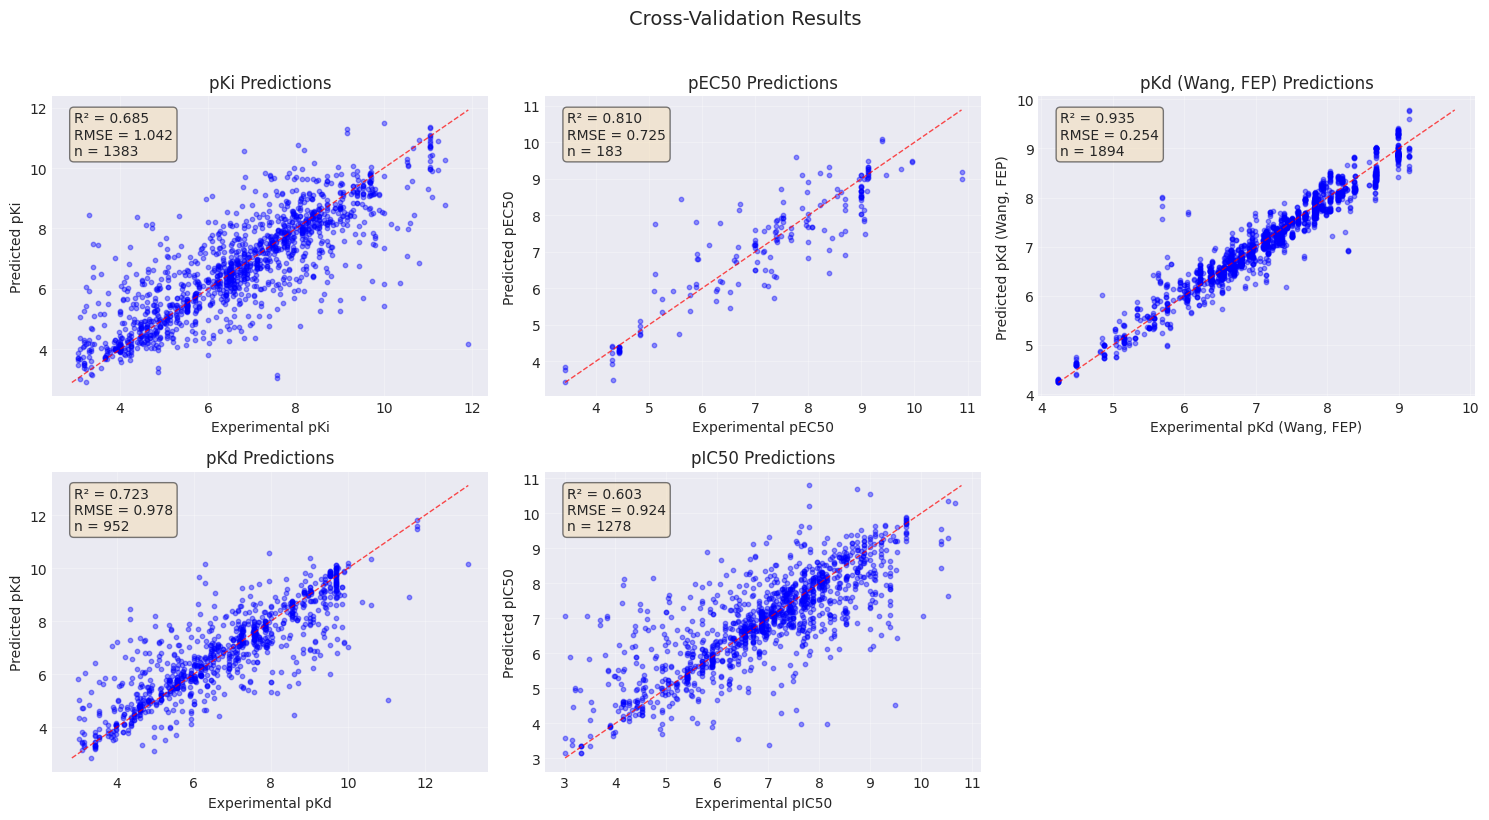

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Plot CV results
if 'cv_results' in locals():
    fig = plot_results(
        cv_results,
        CONFIG['task_cols'],
        save_path=os.path.join(CONFIG['experiment_dir'], 'figures', 'cv_results.png')
    )



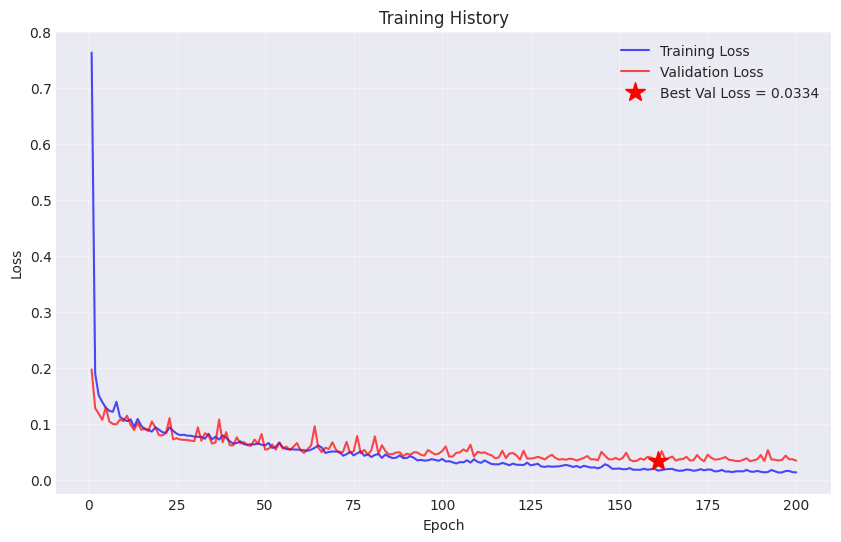

In [38]:
# Plot training history
if 'trainer' in locals() and hasattr(trainer, 'train_losses'):
    from gnn_dta_mtl.evaluation.visualization import plot_training_history
    plot_training_history(
        trainer.train_losses,
        trainer.val_losses,
        save_path=os.path.join(CONFIG['experiment_dir'], 'figures', 'training_history.png')
    )



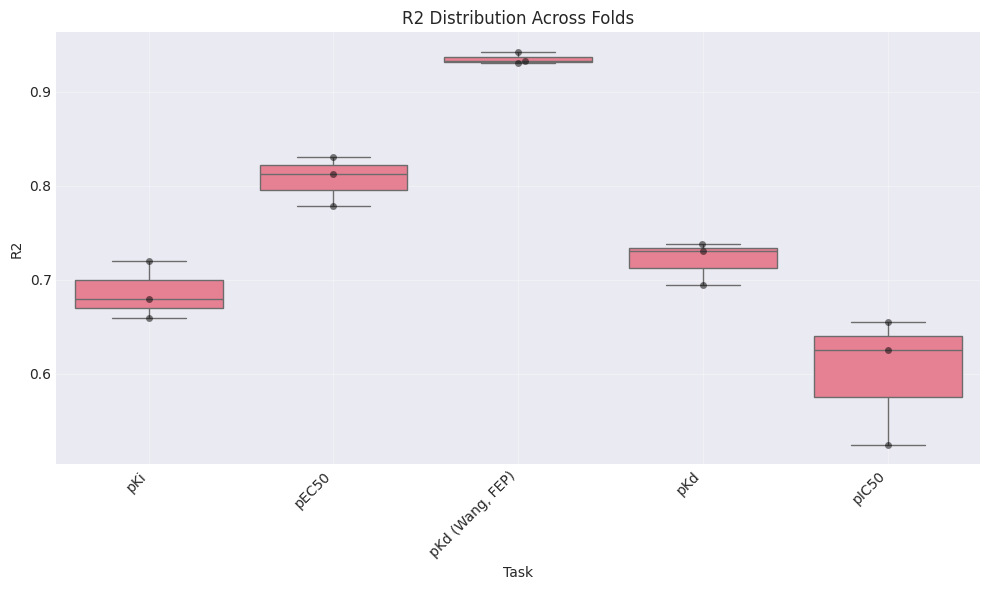

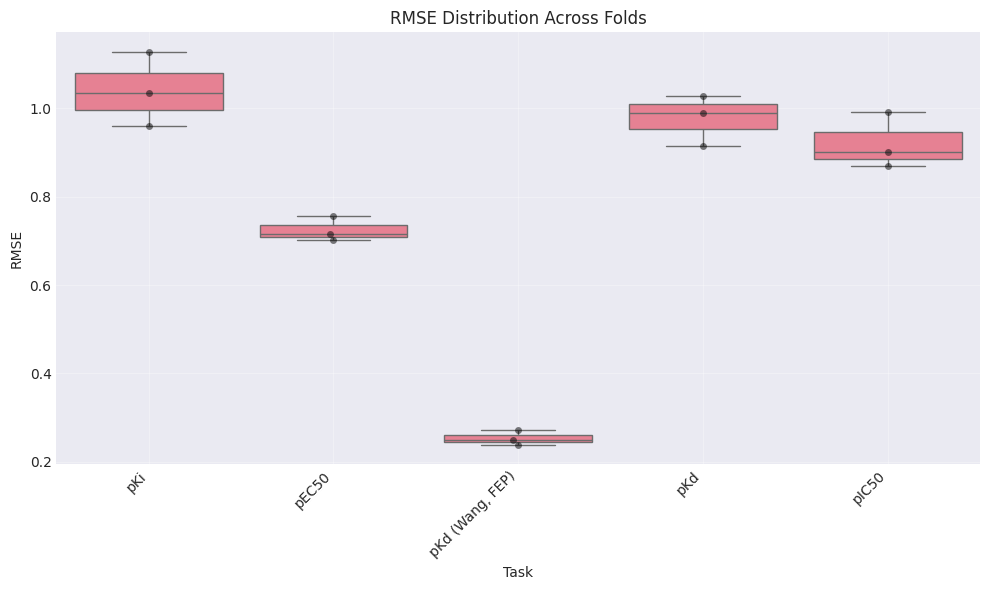

In [39]:
# Plot metrics distribution across folds
if 'cv_results' in locals():
    from gnn_dta_mtl.evaluation.visualization import plot_metrics_distribution
    plot_metrics_distribution(
        cv_results,
        CONFIG['task_cols'],
        metric='r2',
        save_path=os.path.join(CONFIG['experiment_dir'], 'figures', 'r2_distribution.png')
    )
    
    plot_metrics_distribution(
        cv_results,
        CONFIG['task_cols'],
        metric='rmse',
        save_path=os.path.join(CONFIG['experiment_dir'], 'figures', 'rmse_distribution.png')
    )

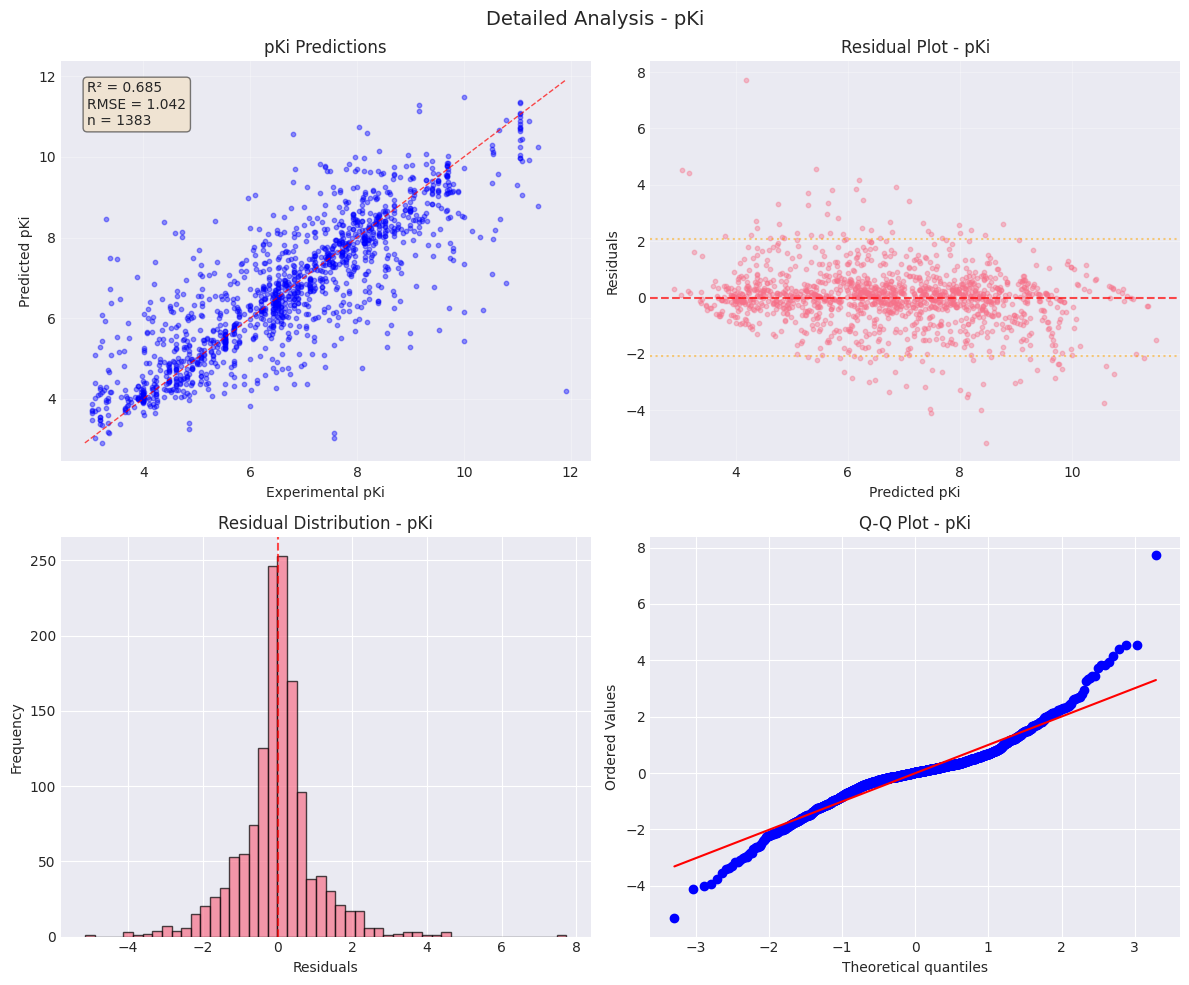

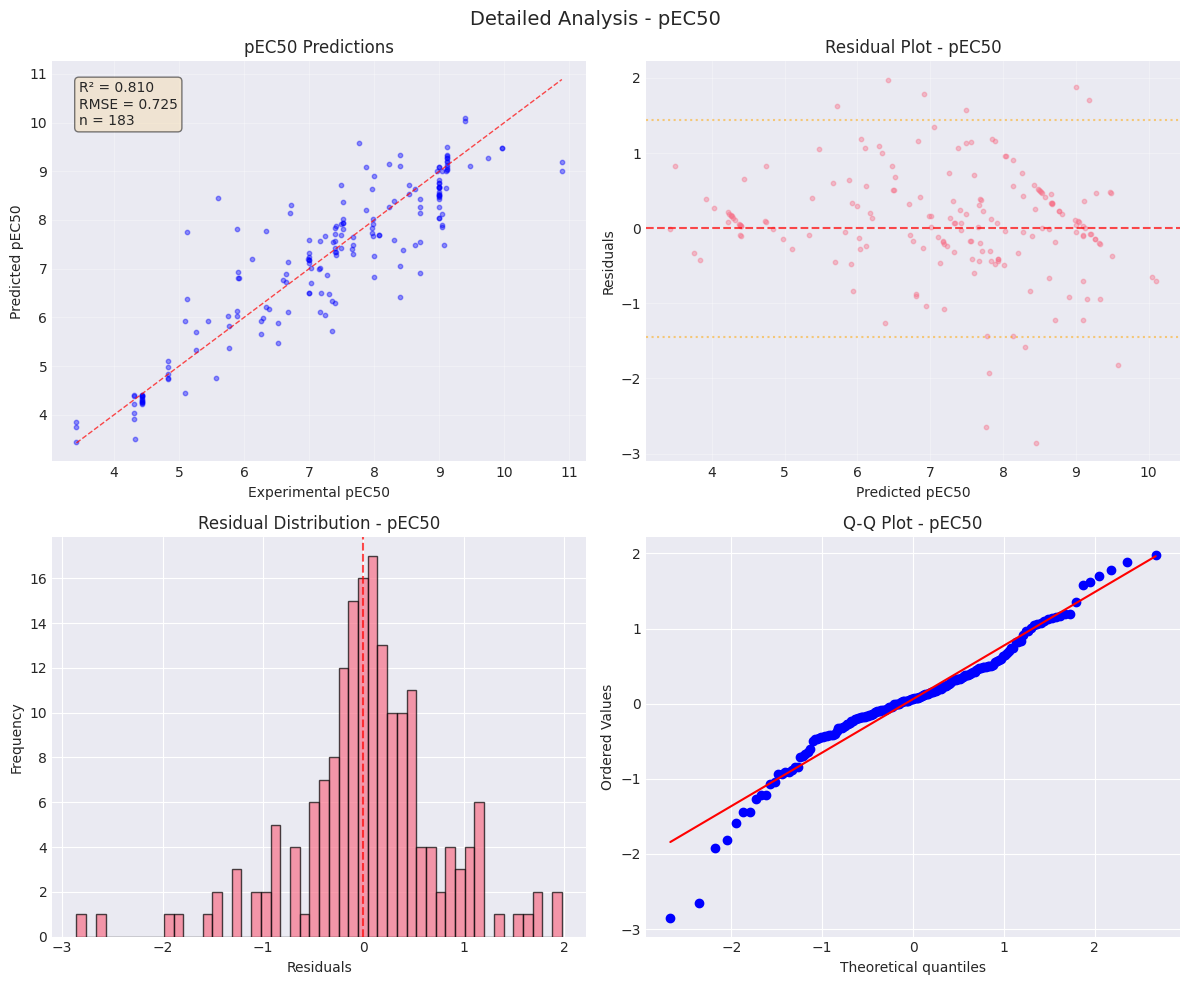

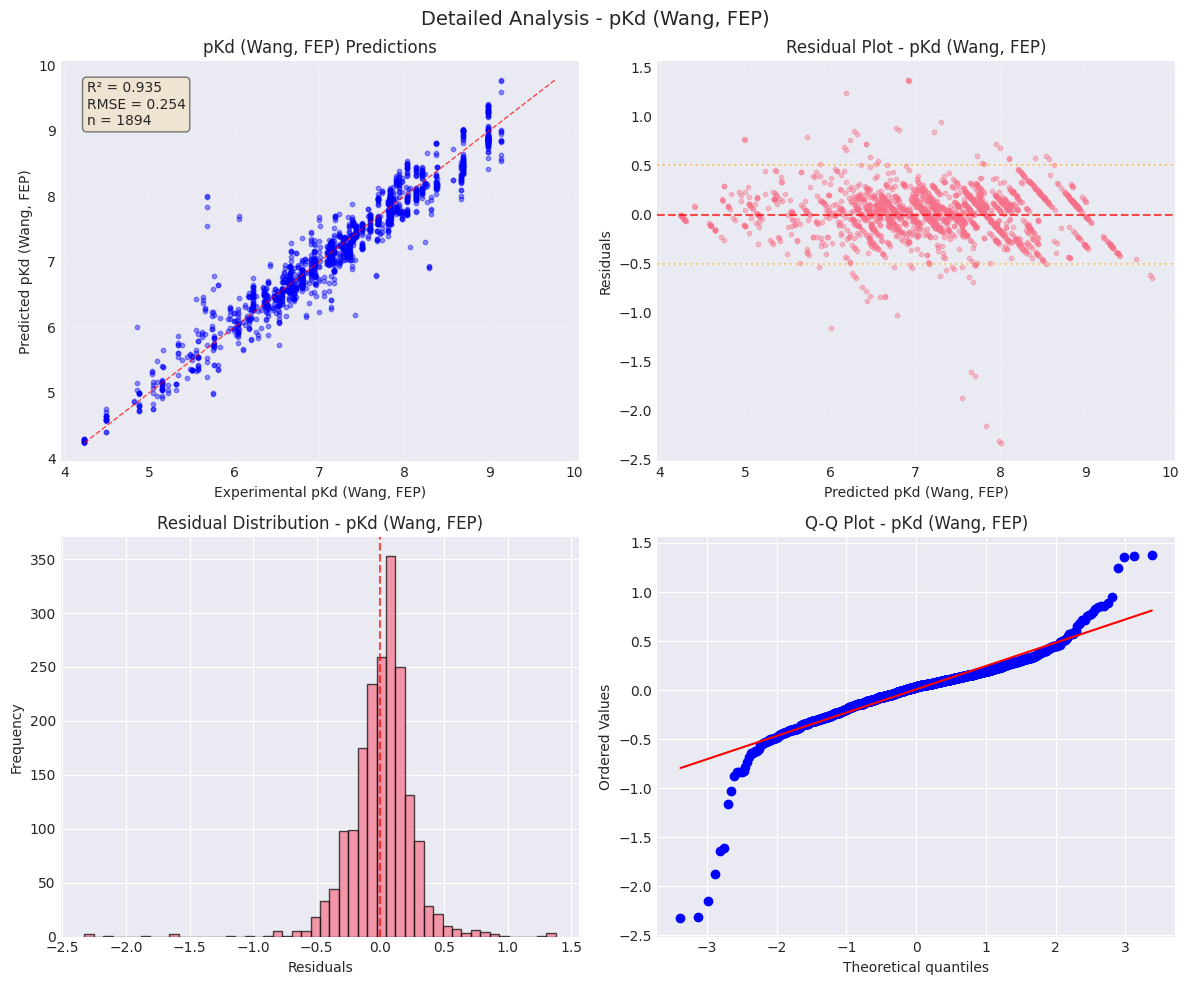

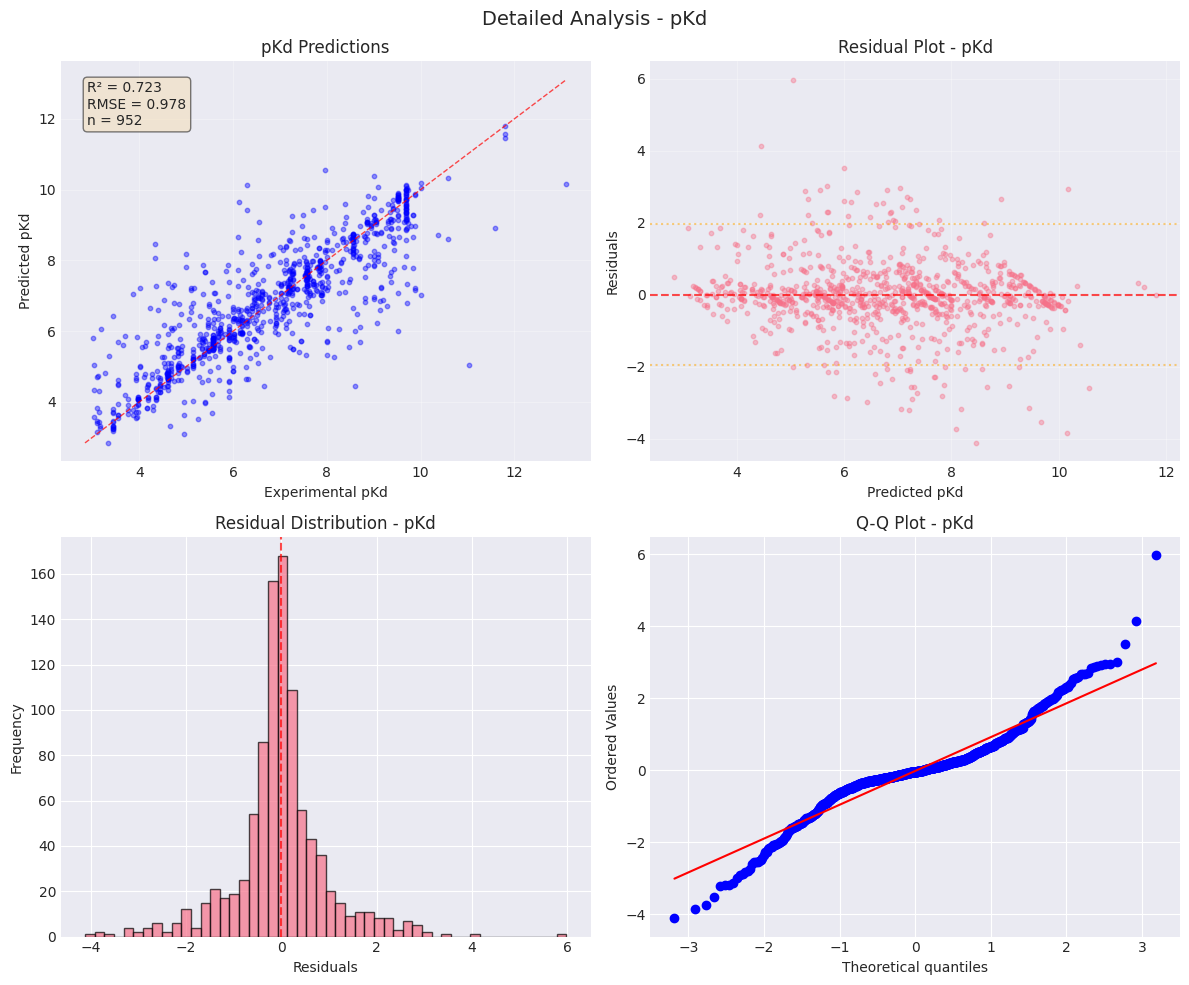

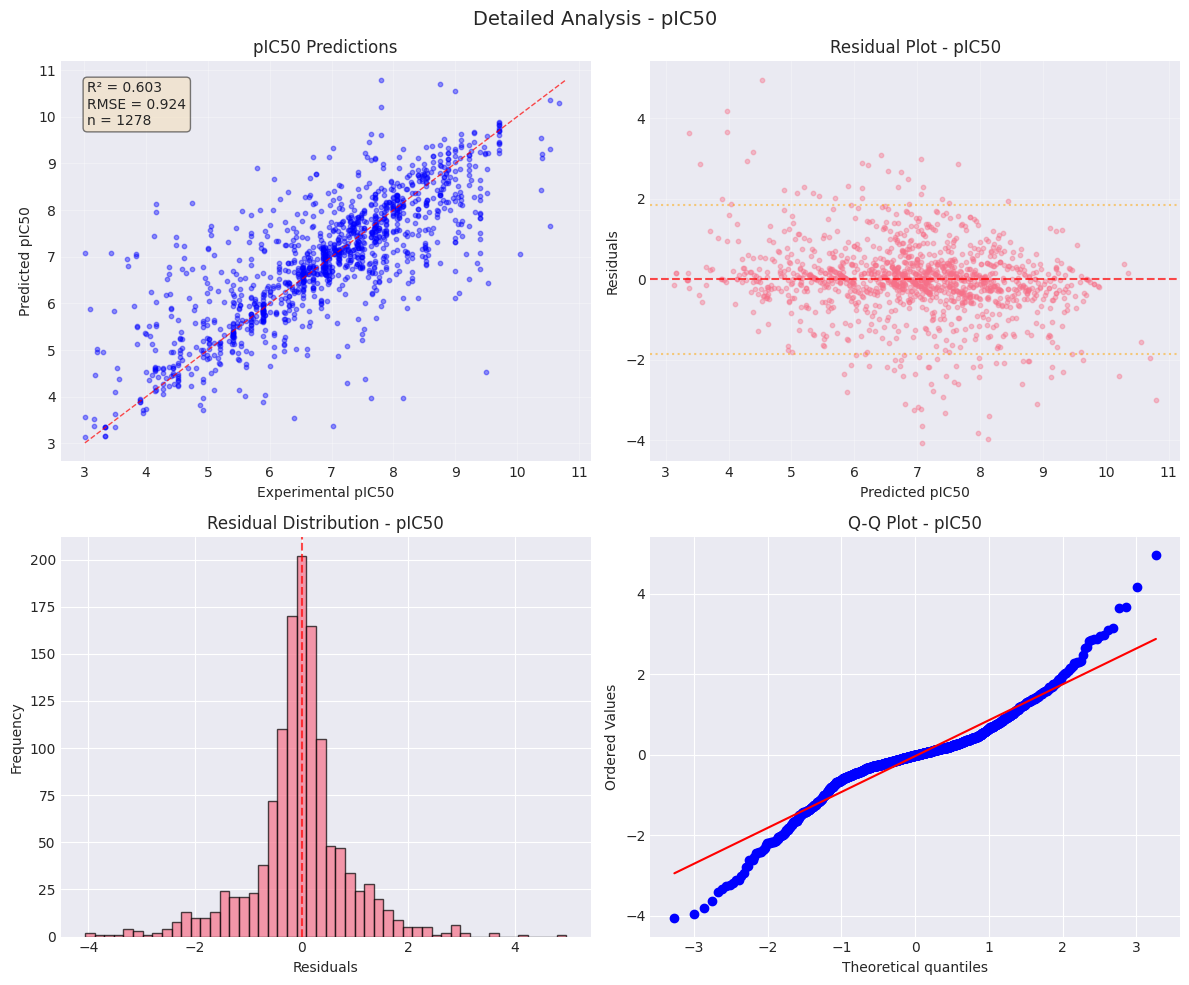

In [34]:
# Analyze prediction errors
if 'cv_results' in locals():
    for task in CONFIG['task_cols']:
        if len(cv_results[task]['all_targets']) > 0:
            targets = np.array(cv_results[task]['all_targets'])
            preds = np.array(cv_results[task]['all_predictions'])
            
            # Calculate residuals
            residuals = targets - preds
            
            # Create figure with subplots
            fig, axes = plt.subplots(2, 2, figsize=(12, 10))
            
            # 1. Predictions vs Targets
            ax = axes[0, 0]
            from gnn_dta_mtl.evaluation.visualization import plot_predictions
            plot_predictions(targets, preds, task, ax)
            
            # 2. Residuals plot
            ax = axes[0, 1]
            from gnn_dta_mtl.evaluation.visualization import plot_residuals
            plot_residuals(targets, preds, task, ax)
            
            # 3. Residual distribution
            ax = axes[1, 0]
            ax.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
            ax.axvline(x=0, color='red', linestyle='--', alpha=0.7)
            ax.set_xlabel('Residuals')
            ax.set_ylabel('Frequency')
            ax.set_title(f'Residual Distribution - {task}')
            
            # 4. Q-Q plot
            ax = axes[1, 1]
            from scipy import stats
            stats.probplot(residuals, dist="norm", plot=ax)
            ax.set_title(f'Q-Q Plot - {task}')
            
            plt.suptitle(f'Detailed Analysis - {task}', fontsize=14)
            plt.tight_layout()
            plt.savefig(
                os.path.join(CONFIG['experiment_dir'], 'figures', f'analysis_{task}.png'),
                dpi=300, bbox_inches='tight'
            )
            plt.show()

In [35]:
# Cell 14: Bootstrap Analysis
from gnn_dta_mtl.evaluation.metrics import bootstrap_metrics

if 'cv_results' in locals():
    print("\nBootstrap Confidence Intervals (95%):")
    
    for task in CONFIG['task_cols']:
        if len(cv_results[task]['all_targets']) > 0:
            targets = np.array(cv_results[task]['all_targets'])
            preds = np.array(cv_results[task]['all_predictions'])
            
            # Calculate bootstrap CIs
            boot_results = bootstrap_metrics(
                targets, preds,
                n_bootstrap=1000,
                confidence=0.95,
                seed=SEED
            )
            
            print(f"\n{task}:")
            for metric, (mean, lower, upper) in boot_results.items():
                print(f"  {metric}: {mean:.3f} [{lower:.3f}, {upper:.3f}]")


Bootstrap Confidence Intervals (95%):

pKi:
  rmse: 1.041 [1.039, 1.043]
  r2: 0.685 [0.683, 0.686]
  mae: 0.694 [0.692, 0.695]

pEC50:
  rmse: 0.723 [0.719, 0.726]
  r2: 0.807 [0.805, 0.809]
  mae: 0.512 [0.510, 0.515]

pKd (Wang, FEP):
  rmse: 0.254 [0.253, 0.255]
  r2: 0.935 [0.934, 0.935]
  mae: 0.173 [0.173, 0.174]

pKd:
  rmse: 0.978 [0.975, 0.980]
  r2: 0.723 [0.721, 0.724]
  mae: 0.639 [0.637, 0.640]

pIC50:
  rmse: 0.922 [0.920, 0.924]
  r2: 0.602 [0.601, 0.604]
  mae: 0.611 [0.610, 0.612]


Model Statistics:
  Total parameters: 3,438,484
  Model size: 13.12 MB


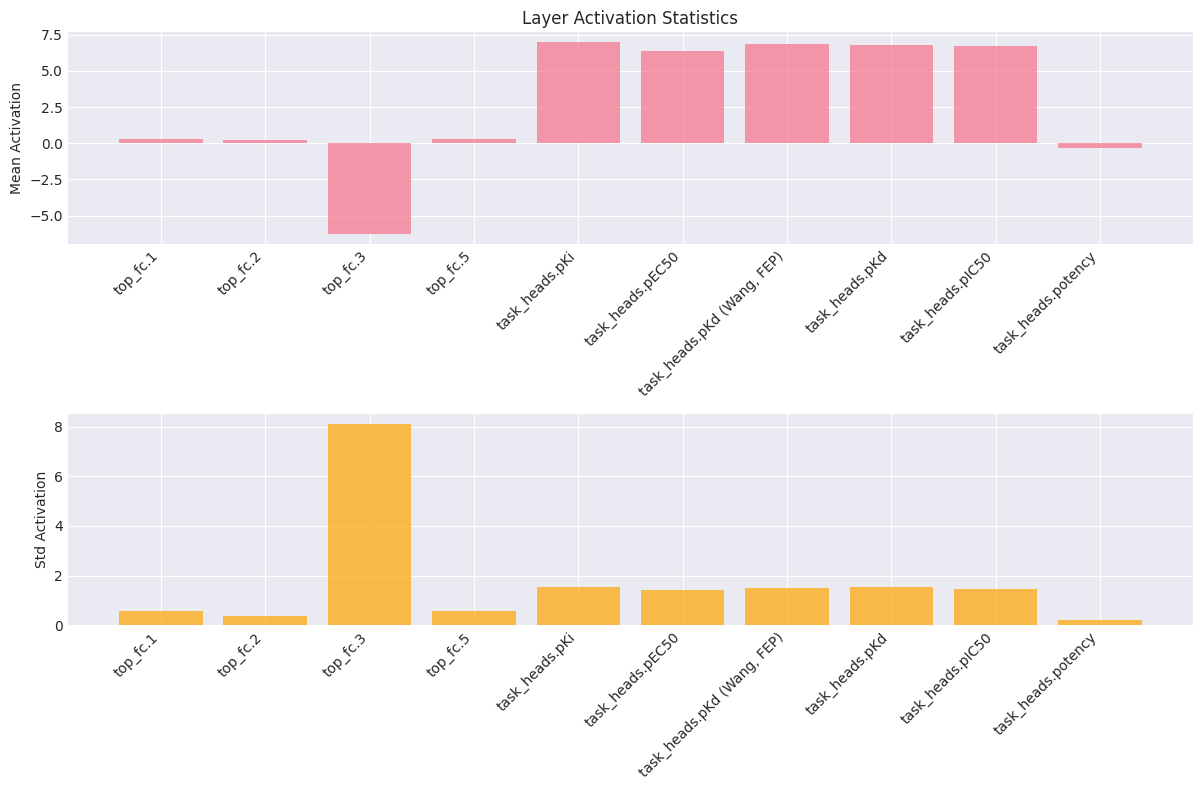

In [36]:
# Cell 15: Analyze Model Features
if 'model' in locals():
    from gnn_dta_mtl.utils.model_utils import (
        count_parameters, 
        get_model_size,
        get_activation_stats
    )
    
    # Model statistics
    n_params = count_parameters(model)
    model_size = get_model_size(model)
    
    print("Model Statistics:")
    print(f"  Total parameters: {n_params:,}")
    print(f"  Model size: {model_size['total_size_mb']:.2f} MB")
    
    # Get activation statistics
    if 'test_loader' in locals():
        act_stats = get_activation_stats(model, test_loader, device)
        
        # Visualize activation statistics
        layers = list(act_stats.keys())[-10:]  # Last 10 layers
        means = [act_stats[l]['mean'] for l in layers]
        stds = [act_stats[l]['std'] for l in layers]
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        
        x = range(len(layers))
        ax1.bar(x, means, alpha=0.7)
        ax1.set_xticks(x)
        ax1.set_xticklabels(layers, rotation=45, ha='right')
        ax1.set_ylabel('Mean Activation')
        ax1.set_title('Layer Activation Statistics')
        
        ax2.bar(x, stds, alpha=0.7, color='orange')
        ax2.set_xticks(x)
        ax2.set_xticklabels(layers, rotation=45, ha='right')
        ax2.set_ylabel('Std Activation')
        
        plt.tight_layout()
        plt.savefig(
            os.path.join(CONFIG['experiment_dir'], 'figures', 'activation_stats.png'),
            dpi=300, bbox_inches='tight'
        )
        plt.show()

# Export


In [18]:
# Cell 16: Export Final Results
import json
from datetime import datetime

# Compile all results
final_results = {
    'experiment_name': experiment_name,
    'timestamp': datetime.now().isoformat(),
    'config': CONFIG,
    'data_stats': {
        'total_samples': len(df),
        'train_samples': len(df_train) if 'df_train' in locals() else None,
        'valid_samples': len(df_valid) if 'df_valid' in locals() else None,
        'test_samples': len(df_test) if 'df_test' in locals() else None
    }
}

# Add CV results summary
if 'cv' in locals() and hasattr(cv, 'summary'):
    final_results['cv_summary'] = cv.summary

# Add test results
if 'test_results' in locals():
    final_results['test_results'] = test_results

# Save comprehensive report
report_path = os.path.join(CONFIG['experiment_dir'], 'final_report.json')
with open(report_path, 'w') as f:
    json.dump(final_results, f, indent=2, default=str)

print(f"\nFinal report saved to: {report_path}")
print(f"All results saved in: {CONFIG['experiment_dir']}")

# Create LaTeX table for publication
if 'cv' in locals() and hasattr(cv, 'summary'):
    print("\nLaTeX Table for Publication:")
    print("\\begin{table}[h]")
    print("\\centering")
    print("\\begin{tabular}{lcccc}")
    print("\\hline")
    print("Task & R² & RMSE & MAE & N \\\\")
    print("\\hline")
    
    for task, metrics in cv.summary.items():
        print(f"{task} & "
              f"{metrics['r2_mean']:.3f}$\\pm${metrics['r2_std']:.3f} & "
              f"{metrics['rmse_mean']:.3f}$\\pm${metrics['rmse_std']:.3f} & "
              f"- & "
              f"{metrics['n_samples']} \\\\")
    
    print("\\hline")
    print("\\end{tabular}")
    print("\\caption{Cross-validation results for multi-task drug-target affinity prediction}")
    print("\\end{table}")


Final report saved to: ../output/experiments/gnn_dta_mtl_experiment_20250911_130831/final_report.json
All results saved in: ../output/experiments/gnn_dta_mtl_experiment_20250911_130831

LaTeX Table for Publication:
\begin{table}[h]
\centering
\begin{tabular}{lcccc}
\hline
Task & R² & RMSE & MAE & N \\
\hline
pKi & 0.686$\pm$0.025 & 1.041$\pm$0.069 & - & 1383 \\
pEC50 & 0.807$\pm$0.022 & 0.724$\pm$0.023 & - & 183 \\
pKd (Wang, FEP) & 0.935$\pm$0.005 & 0.254$\pm$0.014 & - & 1894 \\
pKd & 0.721$\pm$0.019 & 0.978$\pm$0.047 & - & 952 \\
pIC50 & 0.602$\pm$0.056 & 0.920$\pm$0.052 & - & 1278 \\
\hline
\end{tabular}
\caption{Cross-validation results for multi-task drug-target affinity prediction}
\end{table}


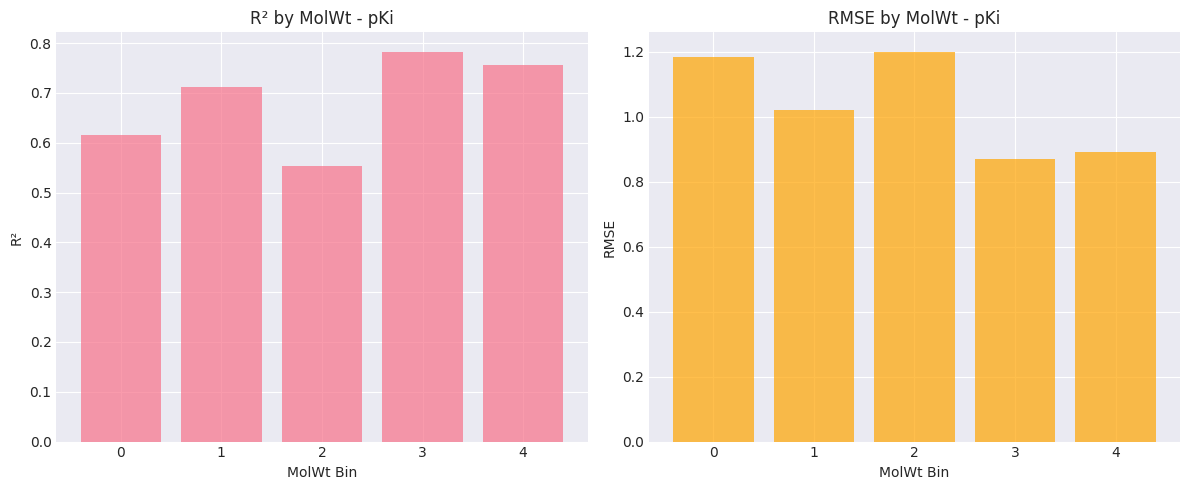

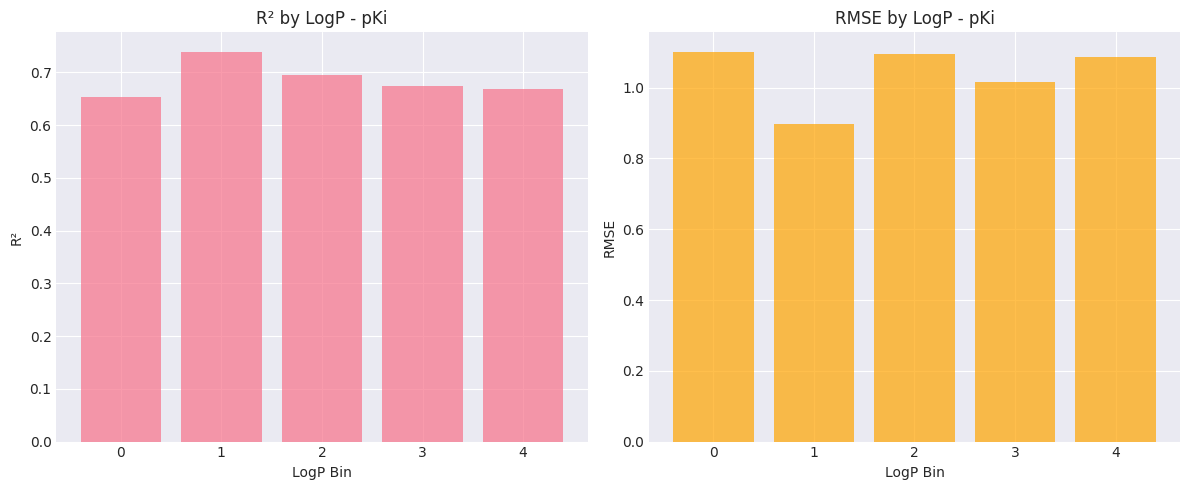

In [19]:
# Cell 17: Interactive Analysis Functions
def analyze_predictions_by_property(task, property_col='MolWt', n_bins=5):
    """Analyze predictions by molecular property"""
    if task not in cv_results or len(cv_results[task]['all_targets']) == 0:
        print(f"No results for {task}")
        return
    
    # Get predictions and targets
    targets = np.array(cv_results[task]['all_targets'])
    preds = np.array(cv_results[task]['all_predictions'])
    
    # Get property values (need to match with original df)
    # This assumes df is still aligned with cv_results
    property_values = df[property_col].values[:len(targets)]
    
    # Create bins
    bins = pd.qcut(property_values, n_bins, labels=False, duplicates='drop')
    
    # Calculate metrics per bin
    from sklearn.metrics import r2_score, mean_squared_error
    
    results = []
    for bin_idx in range(n_bins):
        mask = bins == bin_idx
        if mask.sum() > 0:
            r2 = r2_score(targets[mask], preds[mask])
            rmse = np.sqrt(mean_squared_error(targets[mask], preds[mask]))
            results.append({
                'bin': bin_idx,
                'n_samples': mask.sum(),
                'r2': r2,
                'rmse': rmse,
                f'{property_col}_mean': property_values[mask].mean()
            })
    
    results_df = pd.DataFrame(results)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.bar(results_df['bin'], results_df['r2'], alpha=0.7)
    ax1.set_xlabel(f'{property_col} Bin')
    ax1.set_ylabel('R²')
    ax1.set_title(f'R² by {property_col} - {task}')
    
    ax2.bar(results_df['bin'], results_df['rmse'], alpha=0.7, color='orange')
    ax2.set_xlabel(f'{property_col} Bin')
    ax2.set_ylabel('RMSE')
    ax2.set_title(f'RMSE by {property_col} - {task}')
    
    plt.tight_layout()
    plt.show()
    
    return results_df

# Example usage
if 'cv_results' in locals():
    for task in CONFIG['task_cols'][:1]:  # Analyze first task
        results_by_mw = analyze_predictions_by_property(task, 'MolWt')
        results_by_logp = analyze_predictions_by_property(task, 'LogP')

In [20]:
# Cell 18: Save Session State
import pickle

# Save important objects
session_state = {
    'config': CONFIG,
    'task_ranges': task_ranges,
    'cv_results': cv_results if 'cv_results' in locals() else None,
    'test_results': test_results if 'test_results' in locals() else None,
    'df_stats': {
        'shape': df.shape,
        'columns': df.columns.tolist(),
        'task_coverage': {task: df[task].notna().sum() for task in CONFIG['task_cols']}
    }
}

session_path = os.path.join(CONFIG['experiment_dir'], 'session_state.pkl')
with open(session_path, 'wb') as f:
    pickle.dump(session_state, f)

print(f"Session state saved to: {session_path}")
print("\nTo restore session in a new notebook:")
print(f"with open('{session_path}', 'rb') as f:")
print("    session_state = pickle.load(f)")

Session state saved to: ../output/experiments/gnn_dta_mtl_experiment_20250911_130831/session_state.pkl

To restore session in a new notebook:
with open('../output/experiments/gnn_dta_mtl_experiment_20250911_130831/session_state.pkl', 'rb') as f:
    session_state = pickle.load(f)


In [21]:
1

1